In [1]:
# NOTEBOOK IMPORTS
import os, glob, warnings, pickle, re, traceback
import numpy as np
from shutil import copyfile
from datetime import datetime
from fuzzywuzzy import process
import easyocr

# IMAGE IMPORTS
from PIL import Image
import cv2

# GIS IMPORTS
from affinetransformation import *
from affine import Affine
import pandas as pd
import geopandas as gpd
import rasterio as rio

# IMAGE IMPORTS
# from skimage.morphology import skeletonize
# from skimage import img_as_bool, img_as_ubyte


# PLOTTING IMPORTS
import matplotlib.pyplot as plt

# CUSTOM UTILITIES
from IndexUtils import * 
from TileUtils import *
from TileNameFinder import *
from ReadDate import *
from featurematching import *

Image.MAX_IMAGE_PIXELS = 933120000
warnings.filterwarnings("ignore")
initialize = False

%matplotlib widget

WARNING  Python>=3.10 is required, but Python==3.8.18 is currently installed 


IO directories depending on which machine. 

In [2]:
username = os.getlogin()

dnn_params = {}
dnn_params['CLNN'] = {}
dnn_params['TPNN'] = {}
dnn_params['RLNN'] = {}
dnn_params['FLNN'] = {}
dnn_params['TLNN'] = {}


if username == 'fhacesga':
    base_input_path   = r"D:\RECTDNN\uncompress_2\\"
    base_output_path  = r"D:\RECTDNN\processing\\"
    ref_dir  = r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\\"
    tiled_yolo_model_paths = [
        r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\CORNERS\CornersTiled_111324.pt",
        r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\FANN\FANN_large_YOLO.pt"
    ]
elif username == 'fhace':
    base_input_path   = r"C:\Users\fhace\Desktop\FIRMs\data\Uncompress\\"
    ref_dir = r"C:\Users\fhace\Desktop\FIRMs\data\AAA_ReferenceDatasets\\"
    base_output_path = r"C:\Users\fhace\Desktop\FIRMs\data\Outputs\\"
    # dnn_params['TLNN']['model_weights']    = r"C:\Users\fhace\Desktop\FIRMs\data\BBNN\curr_weights.pt"
    dnn_params['CLNN']['model_checkpoint'] = r"C:\Users\fhace\Desktop\FIRMs\data\RLNN\checkpoint_101423.pth"
    dnn_params['TPNN']['model_checkpoint'] = r"C:\Users\fhace\OneDrive - University Of Houston\AAA_RECTDNN\data\TPNN\checkpoint_091523_pyramids_2.pth"
    dnn_params['RLNN']['model_checkpoint'] = r"C:\Users\fhace\OneDrive - University Of Houston\AAA_RECTDNN\data\RLNN\checkpoint_091323.pth"
    
else:
    base_input_path   = r"D:\Desktop\FIRMsDigitizing\data\HistoricalFIRMS"
    base_output_path  = r"D:\Desktop\FIRMsDigitizing\processing"
    ref_dir  = r"C:\Users\franc\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\\"

if not initialize:
    initialize = init_databases(ref_dir)

try:
    reader
except:
    reader = easyocr.Reader(['en']) 

Create working dir and unzip all files if needed

In [3]:
def getLegendNumber(image, reader):

    im_arry = np.asarray(image).astype(np.uint8) * 255
    im_arry_crop = im_arry[int(-0.05 * im_arry.shape[0]):, int(-0.1 * im_arry.shape[1]):]
    im_arry_crop = cv2.GaussianBlur(im_arry_crop, (1, 1), 1, 1)

    im_scan = reader.readtext(im_arry_crop, detail=1, text_threshold=0.9)

    if len(im_scan) == 0:
        return None

    best = np.argmax([a[-1] for a in im_scan])

    text = re.sub('[^0-9]', "", im_scan[best][1])
    if text == '':
        return None

    return text


In [4]:
remove_files = []

for filename in tqdm(glob.glob(base_input_path + "\\*.tif*")):
    tiff_file = os.path.join(base_input_path, filename)
    try:
    # Check if the file is a multi-page TIFF
        with Image.open(tiff_file) as img:
            if img.is_animated:    
                prev_counter = 0
                print(f"Expanding {os.path.basename(tiff_file)} into {img.n_frames}")
                for i in range(img.n_frames):
                    if i == 0:
                        img.seek(i)
                        output_filename = f"{os.path.splitext(tiff_file)[0]}_IND{os.path.splitext(tiff_file)[1]}"
                        img.save(output_filename, format=img.format)
                    else:
                        try:
                            img.seek(i)
                            text = getLegendNumber(np.asarray(img), reader)

                            if text is not None:
                                output_filename = f"{os.path.splitext(tiff_file)[0]}_{text}.tif"
                                img.save(output_filename, format=img.format)
                                prev_counter = int(text)
                            
                            else:
                                prev_counter = prev_counter+1
                                output_filename = f"{os.path.splitext(tiff_file)[0]}_unsure_{prev_counter}.tif"
                                img.save(output_filename, format=img.format)
                        except:
                            print(f"Error with {tiff_file} page {i}")
                            print(traceback.format_exc())
                            continue
                remove_files.append(tiff_file)
    except Exception as e:
        print(f"Error opening {tiff_file}")
        print(e)
        continue

for tiff_file in remove_files:
   os.remove(tiff_file)

  0%|          | 0/893 [00:00<?, ?it/s]

Error opening D:\RECTDNN\uncompress_2\485510.tif
cannot identify image file 'D:\\RECTDNN\\uncompress_2\\485510.tif'
Error opening D:\RECTDNN\uncompress_2\485510B.tif
cannot identify image file 'D:\\RECTDNN\\uncompress_2\\485510B.tif'
Error opening D:\RECTDNN\uncompress_2\485516A.tif
cannot identify image file 'D:\\RECTDNN\\uncompress_2\\485516A.tif'


In [5]:
# MAKE PROCESSING DIRECTORY
datetime_str = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
proc_dir     = os.path.join(base_output_path, datetime_str)
# proc_dir = r"D:\RECTDNN\processing\2024-11-15_09-31-24\\"
# proc_dir = r"D:\RECTDNN\processing\2025-01-21_17-30-34\\"
proc_dir = r"D:\RECTDNN\processing\2025-01-29_16-17-10\\"

# IF THERE ARE ANY ZIP FILES IN DIRECTORY, UNZIP THEM IN PLACE
if len(glob.glob(base_input_path + "*.zip*")) != 0:
    extractZipFiles(base_input_path, base_input_path)

outputs_dir  = os.path.join(proc_dir, "Outputs")
os.makedirs(outputs_dir, exist_ok=True)

Read through all the images in the directory. Some images are saved as Multi-page TIFF files. These need to be exported into individual images. We'll do that first in-place at uncompressed directory

In [6]:
remove_files = []

for filename in tqdm(glob.glob(base_input_path + "\\*.tif*")):
    tiff_file = os.path.join(base_input_path, filename)
    try:
    # Check if the file is a multi-page TIFF
        with Image.open(tiff_file) as img:
            if img.is_animated:    
                print(f"Expanding {os.path.basename(tiff_file)} into {img.n_frames}")
                for i in range(img.n_frames):
                    try:
                        img.seek(i)
                        output_filename = f"{os.path.splitext(tiff_file)[0]}_{i+1}{os.path.splitext(tiff_file)[1]}"
                        img.save(output_filename, format=img.format)
                    except:
                        print(f"Error with {tiff_file} page {i}")
                        continue
                remove_files.append(tiff_file)
    except Exception as e:
        print(f"Error opening {tiff_file}")
        print(e)
        continue

for tiff_file in remove_files:
    os.remove(tiff_file)

  0%|          | 0/893 [00:00<?, ?it/s]

Error opening D:\RECTDNN\uncompress_2\485510.tif
cannot identify image file 'D:\\RECTDNN\\uncompress_2\\485510.tif'
Error opening D:\RECTDNN\uncompress_2\485510B.tif
cannot identify image file 'D:\\RECTDNN\\uncompress_2\\485510B.tif'
Error opening D:\RECTDNN\uncompress_2\485516A.tif
cannot identify image file 'D:\\RECTDNN\\uncompress_2\\485516A.tif'


Here we're using heuristics to identify indices within all the image files. These include:
- Files that are shorter than 12 characters
- Files that have the ```IND``` marker

We create a Pandas DataFrame with the files matching. We then add several fields as below

In [7]:
# LIST ALL IMAGES IN DIRECTORY
image_files = glob.glob(f"{base_input_path}/*48201*")

# FILTER IMAGES USING HEURISTICS
patterns = ["IND", "_1."]
index_files = [file for pattern in patterns for file in glob.glob(base_input_path + "\\*48201*" + pattern + "*")]
filtered_files = [file for file in image_files if len(os.path.basename(file)) < 12]
index_files.extend(filtered_files)
index_files = [a for a in index_files if "unsure" not in a]

# CREATE DATAFRAME
index_files = pd.DataFrame(index_files, columns=["FilePath"])

# INDEX ATTRIBUTES TO BE ADDED
index_files["Basename"] = [os.path.basename(file) for file in index_files["FilePath"].to_list()]    # BASENAME
index_files["Location"] = index_files["Basename"].apply(extract_numerical_chars).astype(np.int32)   # 
index_files["GEOID"]    = index_files["Location"].apply(getGEOID)       # GET GEOID FOR EACH INDEX
index_files["geometry"] = index_files["GEOID"].apply(getGeometry)       # GET GEOMETRY FROM MATCHING GEOIDs

This is where we perform the ICP for each index...

In [8]:
verbose = True

TPNN = None
RLNN = None
CLNN = None
TLNN = None

# THIS CHECKS WHETHER THE RUN WAS INTERRUPTED
# TO MAKE SURE WE'RE NOT STARTING FROM SCRATCH UNNECESSARILY
try:
    gen_dict
    print("Starting with predefined dict")
except:
    gen_dict = {}

# gen_dict = {}

# OUTPUT DIRECTORY FOR GENERAL RESULTS STRUCTURE
output_struct_dir = os.path.join(outputs_dir, "IndexCoords.pkl")

if not os.path.exists(output_struct_dir):
    for i, row in tqdm(index_files.iterrows(), total=index_files.shape[0]):
        
        try:

            filename = os.path.basename(row["FilePath"])
            
            # THIS CHECKS WHETHER THIS PARTICULAR RASTER WAS RUN ALREADY BY USING THE INDIVIDUAL PKL FILE
            if os.path.exists(os.path.join(outputs_dir, f"{filename}.pkl")):
                print(f"Skipping, found {os.path.join(outputs_dir, filename + '.pkl')}")
                continue

            # READ FILES AND CONVERT TO GRAYSCALE
            image = cv2.imread(row["FilePath"])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image_arry = np.asarray(image)
            
            # SAVE IMAGE TO OUTPUT DIRECTORY
            output_image_fn = os.path.join(outputs_dir, filename.split(".")[0] + ".tif")
            copyfile(row["FilePath"], output_image_fn)

            # GET BOUNDARY POINTS FROM RESPECTIVE SHAPEFILE
            output = getBoundaryPoints(row, distance=100) # TODO: THIS IS THE SAME AS OUR APPROX ACCURACY - MAYBE MAKE IT TIGHTER? 
            if output is None:
                print(f"COULD NOT FIND SHAPEFILE FOR {filename}")
                continue
            point_boundary_gdf, shp_bounds = output
            
            # RUN IMAGES THROUGH DNNs
            classifications, TPNN  = findKeypoints(image, model=TPNN, **dnn_params['TPNN'], legacy=True)
            effectiveArea, RLNN    = findSquares(image, model=RLNN, **dnn_params['RLNN'])
            countyArea, CLNN       = findCounty(image, model=CLNN, **dnn_params['CLNN'])
            tiles, TLNN            = runTLNN(row['FilePath'], outputs_dir, TLNN=TLNN)

            dnn_outputs = {
                "classifications"   : classifications,
                "effectiveArea"     : effectiveArea,
                "countyArea"    : countyArea,
                "tiles"         : tiles
            }
            
            # GET COUNTY BOUNDS IDENTIFIED IN INDEX BY TLNN
            # bounds_panels = tiles["county"]["bbox"]
            bounds_panels = find_bbox(dnn_outputs['countyArea'][:, :, 1])

            # SKIP IF WE CAN'T FIND BOUNDARY IN EXISTING DATABASES
            if point_boundary_gdf is None:
                continue

            # DEFINE BOUNDARY STRUCTU
            boundaries = {
                "point_boundary_gdf"    : point_boundary_gdf,
                "shp_bounds"            : shp_bounds,
                "bounds_panels"         : bounds_panels,
            }

            # WHAT ARE WE LOOKING FOR IN EACH IDENTIFIED SQUARE?
            key = findKey(row["Basename"])    
            if key is None:
                print(f"Could not find key in {filename}")
            
            # DO ICP
            transform_dict = performICPonIndex(boundaries, dnn_outputs, debug=False, plot=True, rotation=False, shear=False, perspective=False, icp_iterations=30, proc_limit=500)

            # GET TRANSFORM FROM ICP TO CRS TRANSFORM
            output_transform, transform_dict = ICPtoCRSTransform(image_arry, transform_dict)

            # GET OUTPUT TRANSFORM INTO AFFINE AND WRITE
            output_affine = Affine(*output_transform.flatten()[:6])
            with rio.open(output_image_fn, 'w',
                driver='GTiff',
                height=image.shape[0], width=image.shape[1],
                count=1, dtype=image.dtype,
                crs=f'EPSG:3857',
                transform=rio.Affine(*output_transform.flatten()[:6])) as dst:
                    dst.write(image, 1)   

            tiles['transform_info'] = transform_dict
            tiles['output_transform'] = output_transform
            tiles['DNN_outputs'] = dnn_outputs
            gen_dict[filename] = tiles
            
            with open(os.path.join(outputs_dir, f"{filename}.pkl"), 'wb') as handle:
                pickle.dump(gen_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        except Exception: 
            print(f'Error with {os.path.basename(row["FilePath"])}')
            print(traceback.format_exc())
            continue
    
    # SAVE AS GENERAL OUTPUT
    with open(os.path.join(outputs_dir, "IndexCoords.pkl"), 'wb') as handle:
        pickle.dump(gen_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(output_struct_dir, 'rb') as f:
        gen_dict = pickle.load(f)

In [9]:
for i, (k, v) in enumerate(gen_dict.items()):
    print(k)

48201CIND0.tif
48201CIND0A.tif
48201CIND0B.tif
48201CIND0C.tif
48201CIND0D.tif
48201CIND0E.tif
48201CIND0F.tif
48201CIND0_0990.jpg
48201CIND0_0992.tif
48201CIND0_1196.tif


In [11]:
smartdict_dir = os.path.join(proc_dir, "SmartDict.p")

if os.path.exists(smartdict_dir):
    with open(smartdict_dir, 'rb') as handle:
        tile_coords = pickle.load(handle)
else:
    tile_coords = smartifyDict(gen_dict, base_input_path, reader, verbose=0, diagnostics=True)

    with open(smartdict_dir, 'wb') as handle:
        pickle.dump(tile_coords, handle, protocol=pickle.HIGHEST_PROTOCOL)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

In [12]:
with open(os.path.join(proc_dir, "SmartDict.p"), 'wb') as handle:
    pickle.dump(tile_coords, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
stateplanes = gpd.read_file(f"{data_dir}/AAA_ReferenceDatasets/stateplane.shp")
intersections = gpd.read_file(f"{data_dir}/AAA_ReferenceDatasets/OSM_Roads/TexasRoads_filtered_strict_3857_nondupe_smaller.gpkg", engine='pyogrio', use_arrow=True)
roads_gdf = gpd.read_file(r"C:\Users\fhacesga\Downloads\TexasRoads_filtered_strict_3857.gpkg", engine='pyogrio', use_arrow=True)
init_databases(f"{data_dir}/AAA_ReferenceDatasets/")

True

Which tiles are we processing?

In [14]:
# LIST ALL IMAGES IN DIRECTORY
image_files = []
wildcards = ['48201']
# wildcards = ['480287']
# wildcards = ['480296']
for w in wildcards:
    image_files.extend(glob.glob(f"{base_input_path}/*{w}*"))
image_files = [f for f in image_files if 'w' not in os.path.splitext(f)[1]]

# FILTER IMAGES USING HEURISTICS TO GET TILEINDICES
patterns = ["IND", "_1."]
index_files = [file for pattern in patterns for file in glob.glob(base_input_path + "\\*" + pattern + "*.*[!w]*")]
filtered_files = [file for file in image_files if len(os.path.basename(file)) < 12]
index_files.extend(filtered_files)
index_files = [a for a in index_files if "unsure" not in a]

# GET ACTUAL TILES
tiles       = list(set(image_files) - set(index_files))
tiles_bns   = [os.path.basename(tile).split(".")[0] for tile in tiles]

Build tile database for detections in images

In [15]:
duplicate_db, non_dupped_dict, dupped_dict = buildDetectedDatabase(gen_dict)

print(len(non_dupped_dict), len(dupped_dict))  

detected_tiles = pd.DataFrame.from_dict(non_dupped_dict).T
detected_tiles['geometry'] = detected_tiles['coords'].apply(bbox_to_polygon)
detected_tiles_gdf = gpd.GeoDataFrame(detected_tiles)
detected_tiles_gdf = detected_tiles_gdf[['geometry']]

586 389


In [16]:
if os.path.exists(os.path.join(proc_dir, "observed_misses.csv")):
    miss_dict = pd.read_csv(os.path.join(proc_dir, "observed_misses.csv"), delimiter="\t")
    for i, r in miss_dict.iterrows():
        new_name = os.path.splitext(r['filename'])[0].replace("_IND", "")
        if new_name[-1].isalpha():
            new_name = new_name[:-1]

        new_name = new_name + f"_{r['tilenumber']}"
        print(new_name)
        tile_coords[new_name] = tile_coords[r['tilename']]

In [36]:
referencing_dir  = os.path.join(proc_dir, "referencing") + "\\"
os.makedirs(referencing_dir, exist_ok=True)

def find_file_with_extension(filename, allowed_extensions, directory):
    for ext in allowed_extensions:
        file_path = os.path.join(directory, f"{filename}.{ext}")
        if os.path.isfile(file_path):
            return file_path
    return None 

counter = 0
bad_counter = 0

# FOR EACH TILE IN THE BASENAME
for tile_name in (pbar := tqdm(tiles_bns)): # tile_names: 
    ref_dir = f"{referencing_dir}{tile_name}.tif"
    if os.path.exists(ref_dir):
        print(f"Found {ref_dir}")
        continue

    # PRETTIFY PPROGRESS BAR AND VERBOSE OUTPUT
    pbar.set_description(f"Bad counter: {bad_counter}")
    counter = counter
    print(f"Processing {tile_name}" + "-" * 50)
    
    # FIND THE CORRECT FILE NAME FOR 
    im_file = find_file_with_extension(tile_name, ['tif', 'jpg', 'png'], base_input_path)

    # MAYBE THE IMAGE FILE WAS NOWHERE TO BE FOUND
    if im_file is None:
        print(f"COULD NOT FIND {tile_name} IMAGE " + '-' * 20)
        continue

    # CURRENT TILE PARAMETERS
    curr_tn = os.path.basename(im_file.split(".")[0])[:-1]  # TILE BASE NAME
    curr_tf = os.path.basename(im_file.split(".")[0])[-1]   # TILE EXTENSION (INDIVIDUAL LETTER)

    # READ TILE IN RASETERIO
    ra = rio.open(im_file)
    bounds  = ra.bounds
    image   = ra.read(1)

    # GET THE BOUNDS USING RLNN - TODO: CHECK LOADING TIMES HERE
    bounds, RLNN = findBounds(im_file, None)

    # IF BOUNDS FOUND, USE. ELSE, USE IMAGE BOUNDS
    if len(bounds[0]) < 1:
        print(f"COULD NOT FIND BOUNDS, USING IMAGE EXTENTS {tile_name}")
        bbox = [0, 0, image.shape[0], image.shape[1]]
        datebox = [ int(image.shape[1] * 0.75), int(image.shape[0] * 0.75), image.shape[1], image.shape[0]]
    else:
        bbox = bounds[0].boxes.xyxy.numpy().astype(np.int32)[0].flatten()
        # ASSUME DATE IS IN LOWER RIGHT OF IMAGE
        # TODO: WE ARE USING DIFFERENT FOR LEGEND - USE THAT INSTEAD.
        datebox = [bbox[2], int(3 * image.shape[0] // 4), image.shape[1], image.shape[0]]


    current_tile_coords = tile_coords.get(curr_tn, None)
    if current_tile_coords is None:
        sec_level = re.sub(r'[a-zA-Z]', '', os.path.basename(im_file.split(".")[0]))
        sec_level = re.sub(r'__', '_', sec_level)
        print(f"Couldn't find strict, now trying {sec_level}")
        current_tile_coords = tile_coords.get(sec_level, None)
        if current_tile_coords is None:
            print(f"Could not find tile in detections {sec_level}")
            bad_counter = bad_counter + 1
            continue
        curr_tn = sec_level
        curr_tf = 0
    
    # GET DATE OF CURRENT TILE FROM DATEBOX, FILTERING WITH HEURISTICS (REVISED, EFFECTIVE)
    tile_datetime = extractDate(image[datebox[1]:datebox[3], datebox[0]:datebox[2]], reader, imsize=4092, filter_values=['revised', 'effective'])

    # CHECK IF WE FOUND A DATE, AND PROCEED ACCORDINGLY
    if tile_datetime[0] is not None: 
        print(tile_datetime)
        # IF FOUND, FIND CLOSEST DATE WITHIN CURRENT KEY
        # tile_dates = extractDatesFromDict(tile_coords[curr_tn], curr_tf)
        # try:
        #    tile_dates.pop(None)
        #except:
        #    continue
        # curr_bbox, closest_date = getBBOXClosestDate(extractDatesFromDict(tile_dates, tile_datetime[0][0]))

        # IF CLOSEST DATE WITHIN CURRENT KEY IS OVER 10 YEARS, RETRY WITH ENTIRE DICT
        # IF FOUND, FIND CLOSEST DATE WITHIN CURRENT KEY

        curr_dates = extractDatesFromDict_legacy(tile_coords[curr_tn], curr_tf)
        if curr_dates.get(None, None) is not None:
            curr_dates[datetime(1900, 1, 1)] = curr_dates[None]
            curr_dates.pop(None)

        curr_bbox, closest_date = getBBOXClosestDate(curr_dates, tile_datetime[0][0])
        if abs(closest_date - tile_datetime[0][0]).days > 3650:
            curr_bbox, closest_date_gen = getBBOXClosestDate(curr_dates, tile_datetime[0][0])
            print(f"CLOSEST DATE IN KEY IS TOO FAR ({abs(closest_date - tile_datetime[0][0]).days} days), using general instead ({closest_date_gen})")

    else: 
        print(f"Could not find date in {tile_datetime[1]}, trying to use {curr_tf}")
        # IF NOT FOUND, USE DEFAULT (0)
        current_tf_coords = current_tile_coords.get(curr_tf, None)
        if current_tf_coords is None:
            print(f"Could not find tile extension in detections {curr_tn} - {curr_tf}, using default {list(current_tile_coords.keys())[0]} from options {current_tile_coords.keys()}")
            curr_tf = list(current_tile_coords.keys())[0]
            curr_bbox = tile_coords[curr_tn][curr_tf]["coords"][0]
        else:
            curr_bbox = current_tf_coords["coords"][0]

    # BOUND BBOX COORDINATE CONVERSIONS
    real_x, real_y = bbox_to_coords_realworld(curr_bbox)
    pic_x, pic_y   = bbox_to_coords_raster(bbox)
    affine = affineTransformation(pic_x, pic_y, real_x, real_y)
    transform = bboxTransformToCRS(affine.matrix, image)

    # OUTPUT NAME DIRECTORY FOR TILES
    
    try:
        with rio.open(ref_dir, 'w',
            driver='GTiff', count=1, dtype=np.uint8,
            height=image.shape[0], width=image.shape[1],
            crs=f'EPSG:3857',
            transform=rio.Affine(*transform.flatten()[:6])) as dst:
                dst.write(image, 1) 
    except:
        print(f"COULD NOT SAVE {ref_dir}")
        continue

    del curr_bbox

  0%|          | 0/383 [00:00<?, ?it/s]

Found D:\RECTDNN\processing\2025-01-29_16-17-10\\referencing\48201C1095J.tif
Found D:\RECTDNN\processing\2025-01-29_16-17-10\\referencing\48201C0405J.tif
Found D:\RECTDNN\processing\2025-01-29_16-17-10\\referencing\48201C0295L.tif
Found D:\RECTDNN\processing\2025-01-29_16-17-10\\referencing\48201C0195M.tif
Found D:\RECTDNN\processing\2025-01-29_16-17-10\\referencing\48201C0420L.tif
Found D:\RECTDNN\processing\2025-01-29_16-17-10\\referencing\48201C0630J.tif
Found D:\RECTDNN\processing\2025-01-29_16-17-10\\referencing\48201C0465J.tif
Found D:\RECTDNN\processing\2025-01-29_16-17-10\\referencing\48201C0840K.tif
Processing 48201C0130G--------------------------------------------------
Couldn't find strict, now trying 482010130
Could not find tile in detections 482010130
Processing 48201C0215G--------------------------------------------------
([datetime.datetime(1990, 9, 28, 0, 0)], ['HARRIS COUNTY,', 'TEXAS AND', 'INCORPORATED AREAS', 'PANEL 215 OF 390', '(SEE MAP INDEX FOA PANELS Not PRINT

01/29/2025 18:28:23 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C1080L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C1080L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C1080L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['T4u4uo CUUI"1 1', 'TEXAS', 'AND NNCORPORATED AREAS', 'PANEL 1080 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL  LAYOUT)', 'CONIAINS _', '1', 'COMMUNITY NumbER > PANEL_> sufaX', 'PASADENA CITY OF 480307 1080', 'HOUSTON, CITY OF 480298 1080', 'TAYLORLAKE VILAGE, GITY CF  4855t3 I0BO', 'HARRIS COUNTY', 'UNINCORPORATED AREAS 480287 10BC', 'WD', 'Notice to User: The Map Number shown balow should be used', 'when   plecing map  orders;  the  Community   Numbar   shown', 'above should be used on insurance applications for the subject', 'community:', 'MAP NUMBER', '48201C1080L', 'MAP REVISED:', 'JUNE 18 , 2007', 'Federal Emergency Management Agency', 'OEPART ,', 'SECUB', 'AND'])
Using 2014-06-09 00:00:00 for tile date 2007-06-18 00:00:00
Processing 48201C1065J--------------------------------------------------
Could not find date in ['HARRIS COUNTY', 'TEXAS AND', 'INCORPORATED

01/29/2025 18:29:35 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0720L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0720L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0720L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['TEXAS', 'AND INCORPORATED AREAS', 'PANEL 720 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL  LAYOUT}', 'CONIAINS', '2', 'COMMUNITY NUMBER > PANEL _> SUFAX', 'HAAAIS COUNTY,', 'UNINCORPORATED AREAS 480287 0720', 'HOUSTCN; CITY OF 480206 0720', 'Notice to Usor: The Map Number shown bolow should bo usod', 'when   placing   map  orders;  tho  Community   Numbar shown', 'above should be Usod on insuranca applications for the subjact', 'communitv:', 'MAP NUMBER', '48201C0720L', 'MAP REVISED:', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'M', 'DEEL', 'GECUR', 'AND'])
Using 2013-10-16 00:00:00 for tile date 2007-06-18 00:00:00
Processing 48201C0280G--------------------------------------------------
([datetime.datetime(1980, 9, 28, 0, 0)], ['HARRIS COUNTY_', 'TEXAS AND', 'INCORPORATED AREAS', 'PANEL 280 OF 390', '(SEE MAP INDEXFoA PANELS NOT PRINTED)', 'CONTAINS:',

01/29/2025 18:29:47 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0640L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0640L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0640L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['TEXAS', 'V', 'AND INCORPORATED AREAS', 'PANEL 640 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL  LAYOUT)', 'CQNTAINS_', 'COMMUNITY NumbeR > PANEL _> SUFFX', '9', 'HOUSTON, CITY OF 480286 0840', 'Notica to User: Tho Map Number shown bolow should be usod', 'whan   placing   map  orders;  the  Community   Nurber   shown', 'above should be Usod on insurance', 'applications for the subjoct', 'community-', 'MAP NUMBER', '48201C0640L', 'MAP REVISED:', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'ObPaRTl', 'SECUR E', 'AND'])
Using 2013-10-16 00:00:00 for tile date 2007-06-18 00:00:00
Processing 48201C1005J--------------------------------------------------
([datetime.datetime(1996, 11, 6, 0, 0)], ['HARRIS COUNTY', 'TEXAS AND', 'INCORPORATED AREAS', 'PANEL 1005 8F 1135', '(SEE MAP INDEX Foh PANELS NOT PRINTED}', 'ONTANS', 'COMMUNTY~ NUMBER   PANEL   SUFFIX', 'HarRI

01/29/2025 18:30:17 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0580L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0580L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0580L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['14f4uu0 #UUi 1 1', 'TEXAS', 'AND NNCORPORATED AREAS', 'PANEL 580 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT)', 'CQNIAINS ', '1', 'CQMMUNTY _ NumbeR > PANEL = SUFFX', 'HARRIS COUNTY,', 'UNINCORPORATED AREAS 480287 0580', 'Notice to Usor: The Map Number shown below should bo usod', 'when   placing   map  orders;  the  Communtty  Numbar  shown', 'above should be Used on Insurance applications for the subjoct', 'communiy', 'MAP NUMBER', '48201C0580L', 'MAP REVISED:', 'JUNE 18 , 2007', 'Federal Emergency Management Agency', 'Tho', 'DEPARTA', 'AND', 'SEC'])
Using 2013-10-16 00:00:00 for tile date 2007-06-18 00:00:00
Processing 48201C0145G--------------------------------------------------
COULD NOT FIND BOUNDS, USING IMAGE EXTENTS 48201C0145G
([datetime.datetime(1990, 9, 28, 0, 0)], ['ZONEX', 'HARRIS COUNTY', 'RM 332', 'TEXAS AND', 'INCORPORATED AREAS', 'ZONE', 

01/29/2025 18:30:34 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0430L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0430L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0430L--------------------------------------------------
Could not find date in ['TEXAS', 'AND INCORPORATED AREAS', 'PANEL 430 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL  LAYOUT)', 'CONTAINS_', 'COMMUNITY NUMBER > PANEL _> SVFFX', '1', 'HAUNISCOIFOFATED AFEAS}x 480287  0430', 'HOUSTON, CITY OF 480296 0430', 'Notice to User: The Map Number shown below should be used', 'when   placing   map  orders;  the  Community   Number   shown', 'above should be usad on insurance applications for the subject', 'community:', 'I', 'MAP NUMBER', '48201C0430L', 'MAP REVISED:', 'NinT', 'JUNE 18 , 2007', 'miTTI', 'Federal Emergency Management Agency', 'The', 'User:', 'DEPARTA', 'SECURI', 'AND'], trying to use L
Processing 48201C0440J--------------------------------------------------
([datetime.datetime(1996, 11, 6, 0, 0)], ['HARRIS COUNTY', 'TEXAS AND', 'INCORPORATED   AREAS', 'PANEL 440 OF 1135', '(SEE MAP INDEX FOn PANELS NOT PRINTED)', 'CONTAINS:', 'COMMUMTYFJUMBER   PANE   SUFF

01/29/2025 18:30:44 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0695L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0695L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0695L--------------------------------------------------
Could not find date in ['144uu0 #UUI" 1 1 =', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 695 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL  LAYOUT)', 'CONTAINS', 'Oz', 'COMMUNITY NuMbER > PANEL _> SufFX', 'WD', 'HOUSTON, CITY OF 480206 0605', 'JACINTO CITY, CITY OF 480299 0505', 'GALENA PAFK CITY OF 480283 0605', 'Notica t0 User: Tha Map Number shown bolow should b0 usod', 'when   placing   map  orders;   the  Community   Numbar shown', 'above should be used on insurance  applications for the subjoct', 'community:', 'MAP NUMBER', '48201C0695L', 'MAP REVISED:', 'AND', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'DEPAR', 'SECS'], trying to use L


01/29/2025 18:30:49 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0480L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0480L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0480L--------------------------------------------------
Could not find date in ['Tuuuuu CUUI 1 1', 'TEXAS', 'W', 'AND INCORPORATED AREAS', 'PANEL 480 OF 1150', '{SEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT)', 'CONTAINS;', 'COMMUNTY NUMBER = PANEL _= SUFFIX', '9', 'HOHRIOCOCNYOF  480298   0480', 'UNINCORPORATED AREAS 480287 0480', 'Notice to Usor: The Map Number shown below should be usod', 'whon   placing   map   ordors;   the   Community   Number   shown', 'above should bo used on insurance applications for the subject', 'communitv:', 'MAP NUMBER', '48201C048OL', 'MAP REVISED:', 'AND', 'JUNE 18 , 2007', 'Federal Emergency Management Agency', 'F1', 'DEPARTA', 'SECUB'], trying to use L
Processing 48201C0325G--------------------------------------------------
([datetime.datetime(1990, 9, 28, 0, 0)], ['HARRIS COUNTY', 'TEXAS AND', 'INCORPORATED AREAS', 'PANEL 325 OF 390', '(SEE MAP INDEX FoA PANELS Not PRINTED)', 'CONTAINS:', 'COMMUNITY _ 9  NUMBE . PANEL   SUFFIX', 'h

01/29/2025 18:30:58 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0515L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0515L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0515L--------------------------------------------------
Could not find date in ['LL HJJ1', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 515 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL  LAYOUT)', 'CQNTAINS_', '9', 'COMMUNITY_ NuMBER = PANEL   SUFFX', '2', 'HARISCCOPORATED AREAS} 480287  0515', 'Notica to Usar: Tha Map Number shown bolow should bo usad', 'when', 'placing   map   orders;   tho  Community   Number   shown', 'above should be usad on insuranco applications for the subjact', 'community', 'MAP NUMBER', '48201C0515L', 'MAP REVISED:', 'AND', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'Tho', 'SECUR'], trying to use L
Processing 48201C0885M--------------------------------------------------
([datetime.datetime(2017, 1, 6, 0, 0)], ['HARRIS COUNTY,', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 885 OF 1150', '(SEE MAP INDEX FOR FIRM PANEL LAYOUT )', 'CONTAINS:', 'COMMUNITY NUMBER   PANEL   SUFFIX', 'GALENA PARK CITy OF 480293  0885 m', 'HARRIS COUNTY 48

01/29/2025 18:31:28 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0620L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0620L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0620L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['Iuo CUUlv4 1 ,', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 620 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL  LAYOUT)', 'CQNIAINS', 'COMMUNITY _ NUMBER PANEL _ SUFAX', 'HOUSTON, CITY OF 480296 0620', 'HARRIS COUNTY,', '3', 'UNINCORPORATED AREAS 480287 0620', 'Notice to Usor: The Map Number shown bolow should bo usod', 'placing   map   orders;   the   Community   Number  shown', 'above should be usod on insuranco applications for the subjact', 'community', 'MAP NUMBER', '48201C0620L', 'MAP REVISED:', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'Tho', 'Map', 'whon', 'SECUR', 'AND'])
Using 2013-10-16 00:00:00 for tile date 2007-06-18 00:00:00
Processing 48201C0665K--------------------------------------------------
([datetime.datetime(2000, 4, 20, 0, 0)], ['HARRIS COUNTY', 'TEXAS AND', 'INCORPORATED AREAS', 'PANEL 665 OF 1135', '{SEE MAP INDEX FoR PANELS NoT 

01/29/2025 18:31:45 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0920L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0920L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0920L--------------------------------------------------
Could not find date in ['TEXAS', 'AND INCORPORATED AREAS', 'L', 'PANEL 920 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT)', 'CONTAINS _', 'COMMUNTY NUMBER > PANEL _> SUFFIX', 'W', 'DEERPAFK CITY OF 480201 0820', 'PASADEIA CHTY OF 480307 0820', 'HOUSTON, CITY OF 480206 0820', 'HL', 'WD', 'Notice to Usor: The Map Numbar shown bolow should be usod', 'whan   placing   map   ordars;   the  Community   Number   shown', 'above should be usod on insuranca applications for the subject', 'communiy', 'MAP NUMBER', '48201C0920L', 'MAP REVISED:', 'AND', 'JUNE 18 , 2007', 'Federal Emergency Management Agency', 'DEPAR', 'SECUR'], trying to use L
Processing 48201C0930J--------------------------------------------------
([datetime.datetime(1996, 11, 6, 0, 0)], ['HARRIS COUNTY', 'TEXAS AND', 'INCORPORATED   AREAS', 'PANEL 930 OF 1135', '(SEE MAP INDEX FOR', '~PANELS NOT PRINTED)', 'CONTAIS', 'COMMUNITY _ NUMBER   PANEL

01/29/2025 18:32:08 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C1065L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C1065L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C1065L--------------------------------------------------
Could not find date in ['L4LAL ~JI 1 1', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 1065 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT}', 'CQNIAINS _', '9', 'COMMUNITY NumbeR > PANEL _= SUFFX', 'HAARIS COUNTY ,', 'UNINCORPORATED AREAS 480287 1085', 'PEARLAND, CITYOF 480077 1065', 'Notico to Usar; Tha Map Number shown bolow should be Usod', 'whon   placing   map   ordors;   the   Community   Number   showh', 'above should b0 usod on insurance applications for tho subject', 'community:', 'MAP NUMBER', '48201C1065L', 'MAP REVISED:', 'AND SEC', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'Map', 'OEPARTA'], trying to use L
Processing 48201C0020G--------------------------------------------------
([datetime.datetime(1990, 9, 28, 0, 0)], ['HARRIS COUNTY', 'TEXAS AND', 'INCORPORATED AREAS', 'PANEL 20 OF 390', '(SEE MAP INDEX FoR PANELS Not PRINTED)', 'CONTAINS:', 'CoMMunIiY 2  NUMBER   PANEL = SUFF

01/29/2025 18:33:03 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0605L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0605L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0605L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['14uu UUI" 1 1 ,', 'TEXAS', 'AND INCORPORATED AREAS', 'WWL', 'PANEL 605 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT)', 'CONIAINS:', 'COMMUNITY NUMBER > PANEL   SUFFX', 'E', 'HAAFISCCOUHNHYATED AREAS} 480287 } 0605', 'HOUSTON, CITY OF 480296 0605', 'Mc', 'WD', 'LLLLLU', 'QD', 'Notice to User: Tho Map Number shown below should be Used', 'whon', 'placing   map  ordars;   the  Community   Mumber  shown', 'above should be used on insurance   applications for the subject', 'community-', 'MAP NUMBER', '48201C0605L', 'MAP REVISED:', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'UI', 'Tho', 'Map', 'OEPARTM', 'BECUI', 'AND'])
Using 2013-10-16 00:00:00 for tile date 2007-06-18 00:00:00
Processing 48201C0495J--------------------------------------------------
([datetime.datetime(1996, 11, 6, 0, 0)], ['HARRIS COUNTY', 'TEXAS AND', 'INCORPORATED   AREAS', 'PANE

01/29/2025 18:33:15 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0235L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0235L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0235L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['1444AU #Jia', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 235 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT)', 'CONIAINS ', 'COMMUNITY NUMBER _> PANEL = SUFFX', 'HARAIS COUNTY,', 'UNINCORPORATED AREAS 480287 0235', 'HOUSTON, CITY OF 480206 0235', 'Notice to Usor; Tha Map Number shown below should be usod', 'when   placing   map  ordors;   the  Community   Number   shown', 'above should be usod on insuranco applications for the subjact', 'community:', 'MAP  NUMBER', '48201C0235L', 'MAP REVISED:', 'JUNE 18 , 2007', 'Federal Emergency Management Agency', 'User;', 'DEPARTA', 'SEC ', 'AND'])
Using 1900-01-01 00:00:00 for tile date 2007-06-18 00:00:00
Using 1900-01-01 00:00:00 for tile date 2007-06-18 00:00:00
CLOSEST DATE IN KEY IS TOO FAR (39249 days), using general instead (1900-01-01 00:00:00)
Processing 48201C0070G-----------------------------------------------

01/29/2025 18:33:30 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0755L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0755L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0755L--------------------------------------------------
Could not find date in ['TEXAS', 'V', 'AND INCORPORATED AREAS', 'PANEL 755 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT)', 'CQNTAINS ', '8', 'COMMUNITY NUMBER > PANEL_ > suFFX', 'MAYTOWN, CITY OF 485456 0755', 'HAARIS COUNTY', 'UNINCORPORATED AREAS 480287 0755', 'WUD', 'LLLL', 'QD', 'QL', 'Notice to Usor: The Map Number shown bolow should be used', 'when   plecing   map   orders;   the  Community   Mumber  shown', 'above should be used on insuranca applications for the subject', 'community-', 'MAP NUMBER', '48201C0755L', 'MAP REVISED:', 'AND', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'LLLL', 'DEPART', 'SECUR'], trying to use L
Processing 48201C0175G--------------------------------------------------
([datetime.datetime(1990, 9, 28, 0, 0)], ['HARRIS COUNTY', 'TEXAS AND', 'INCORPORA TED AREAS', 'PANEL 175 OF 390_', '(SEE MAP INDE', 'Foa PANeLS Not PRINTED}', 'CONTAINS:;', 'COMmunITYa  WU

01/29/2025 18:34:03 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C1095L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C1095L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C1095L--------------------------------------------------
Could not find date in ['T4iuuo CUUI 1 1 ,', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 1095 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT)', 'CONTAINS _', 'COMMUNITY NUMBER > PANEL _> SUFHX', '5', 'ELLAGO, ClTY OF 485466 1085', 'HARAS COUNTY', 'UNINCORPORATED AREAS 480287 1085', 'SEABROOK, CITY OF 485507 1095', 'Notice to Usor: The Map Number shown below should be used', 'whon   placing   map  orders;   the  Community   Number   shown', 'above should bo used on insurance applications for the subjoct', 'community:', 'MAP NUMBER', '48201C1095L', 'MAP REVISED:', 'TTT', 'JUNE 18 , 2007', 'Federal Emergency Management Agency', 'QEPARTM', 'SECU', 'AND'], trying to use L
Processing 48201C0590J--------------------------------------------------
([datetime.datetime(1996, 11, 6, 0, 0)], ['HARRIS COUNTY', 'TEXAS AND', 'INCORPORATED   AREAS', 'PANEL 590 OF 1135', '{SE= MAP INDEX FOR  PANELS NOT PRINTED)', 'CONIAI

01/29/2025 18:34:11 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0270L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0270L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0270L--------------------------------------------------
Could not find date in ['4A #AL>1', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 270 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT}', 'CONTAINS _', 'COMMUNITY_ NUMBER _> PANEL _  SUFFX', 'HARRIS COUNTY,', 'UNINCORPORATED AREAS 480287 0270', 'HOUSTON, CITY OF 480296 0270', '~D', 'Notico to Usor: Tho Map Number shown bolow should be used', "'[HWLLL ", 'whon   placing   map  orders;  the  Community   Number   shown', 'abovo should bo Usod on insurance   applications for the subject', 'communiv:', 'MAP NUMBER', '48201CO27OL', 'MAP REVISED:', 'AND', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'DEPAR', "SEC'"], trying to use L


01/29/2025 18:34:16 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0595L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0595L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0595L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['nuvuo LUUi1 1', 'TEXAS', '4 W', 'AND INCORPORATED AREAS', 'Kl  PANEL 595 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL  LAYOUT)', 'CONTAINS', 'W', '8', 'COMMUNITY NUMBER _  PANEL _  SUFHX', 'HARAIS COUNTY,', 'UNINCORPORATED AREAS 480287 0505', 'HOUSTON, CITY OF 480296 0595', 'E', 'TuWD', 'Notico t0 Usar: The Map Number shown bolow should bo usod', 'whon   placing   map  orders;   tho  Community   Number   shown', 'above should bo usod on insurance applications for the subject', 'communiy:', 'MAP NUMBER', '48201C0595L', 'MAP REVISED:', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'DBPARTA', 'SECUR', 'AND'])
Using 2013-10-16 00:00:00 for tile date 2007-06-18 00:00:00


01/29/2025 18:34:20 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0955L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0955L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0955L--------------------------------------------------
Could not find date in ['144440 JUI 1 1', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 955 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT)', 'CONTAINS _', 'COMMUNITY NUMBER _> PANEL _  SUEFX', '8', 'BAYTOW, CITY OF 485456 0855', 'MORGANS POINT, CITY OF 480305 0855', 'HARRIS COUNTY,', 'UNINCORPORATED AREAS 480287 0955', 'LA PORTE CITY OF 485487 0855', 'I', 'WWD', 'QD', 'Notice to Usor: Tha Map Number shown below should be Usad', 'when  placing   map  ordors;  tho  Community   Number   shown', 'abova should bo Usod on insurance applications for the subject', 'communitv-', 'MAP NUMBER', '48201C0955L', 'MAP REVISED:', 'AND', 'JUNE 18 , 2007', 'Federal Emergency Management Agency', 'DEPARTA ', 'SECUR'], trying to use L
Processing 48201C0185J--------------------------------------------------
([datetime.datetime(1996, 11, 6, 0, 0)], ['HARRIS  COUNTY', 'TEXAS AND', 'INCORPORATED   AREAS', 'PANEL 185 OF 1135', 'i

01/29/2025 18:34:32 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0240L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0240L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0240L--------------------------------------------------
Could not find date in ['1444uU #UJI" 1 1', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 240 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL  LAYOUT)', 'CONTAINS ', '0', 'LUM |  coMMUNTY_ NUMBER = PANEL _> SUFFX', 'HARRIS COUNTY', 'UNINCORPORATED AREAS 480287 0240', 'HOUSTON, CITY OF 480288 0240', 'LL', 'WD', 'QD', 'Notice to User; The Map Number shown bolow should be usad', 'whon   placing   map  orders;   tho  Community   Number   shown', 'above should bo used on Insuranco  applications for the subject', 'communitv:', 'MAP NUMBER', '48201C0240L', 'MAP REVISED:', 'AND', 'JUNE 18 , 2007', 'Federal Emergency Management Agency', 'OEPARTM', "SECUR'"], trying to use L
Processing 48201C0660K--------------------------------------------------
Could not find date in ['np Taindd en', 'HARRIS  COUNTY', 'TEXAS AND', 'INCORPORATED  AREAS', 'PANEL 660 OF 4135', '(SEE MAP INDEX FOR PANELS NOT PRINTED}', 'CONTAINS:', 'COMMUNTY _

01/29/2025 18:34:44 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0890L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0890L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0890L--------------------------------------------------
Could not find date in ['LL XNJ#ie_', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 890 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT)', 'CQNIAINS ', 'CQMMUNITY NUMBER > PANEL = SuFFIX', 'HOUSTON, CITY OF 480286 0880', '1', 'Notico to Usor; Tha Map Numbar shown bolow should bo usod', 'whon   placing   map ordert;  the  Communlty   Number   shown', 'ebove should b0 Usod on insurance applications for the subject', 'community', 'MAP NUMBER', '48201C0890L', 'MAP REVISED:', 'AND', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'OEPARTA', 'SEC'], trying to use L


01/29/2025 18:34:49 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0385L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0385L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0385L--------------------------------------------------
Could not find date in ['nfuuuu LUUin1 1', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 385 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT}', 'CQNTAINS;', 'COMMUNITY NUMBER > PANEL ]= SUFFX', '7', 'HARRIS COUNTY,', 'UNINGORPORATED AREAS 480287 0385', 'HOUSTON, GITY OF 480296 0385', 'LD', 'Notice to User: The Map Number shown below should bo used', 'wtheh', 'placing   map  orders;  the  Community   Number   shown', 'above should be used on insurance   applications for the subjoct', 'community-', 'MAP NUMBER', '48201C0385L', 'MAP REVISED:', 'AND', 'JUNE 18 , 2007', 'Federal Emergency Management Agency', 'DEPARTL', 'SECUR E'], trying to use L
Could not find tile extension in detections 48201C0385 - L, using default 0 from options dict_keys([0, 'M', 'G'])
Processing 48201C0025G--------------------------------------------------
([datetime.datetime(1990, 9, 28, 0, 0)], ['HARRIS COUNTY,', 'TEXAS AND', 'INCORPOR

01/29/2025 18:35:07 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0765L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0765L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0765L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['TEXAS', 'AND INCORPORATED AREAS', 'PANEL 765 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL  LAYOUT)', 'CONTAINS  ', '4E', 'COMMUNITY_ MUMBER > PANEL _> SVFRX', 'DAYTOWN;, CITY OF 485456 0765', '1', 'HAIRISCOPORATED AREASx 480287  0765', 'WD', 'Notice to Usor; The Map Number shown balow should b0 usod', 'when', 'placing   map   ordors;   the   Community  Number   shown', 'above should be usad oninsurance applications for the sUbject', 'community', 'MAP NUMBER', '48201C0765L', 'MAP REVISED:', 'JUNE 18 , 2007', 'Federal Emergency Management Agency', 'Tho', 'DEPAR', 'SECUE', 'AND'])
Using 2013-10-16 00:00:00 for tile date 2007-06-18 00:00:00
Processing 48201C1030K--------------------------------------------------
Could not find date in ['HARRIS COUNTY', 'TEXAS AND', 'INCORPORATED   AREAS', 'PANEL 1030 OF 1135', '(SEE MAP INDEX FOR PANELS NoT PRINTED)', 'CONTAINS', 'COMMU

01/29/2025 18:35:29 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0940L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0940L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0940L--------------------------------------------------
Could not find date in ['irUA JUOi" 1 Le', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 940 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT}', 'CONTAINS;', 'Jwwl |   cOMMUNiTY_ NUMBER   PANEL _  SUFAX', 'DEFR PARK, GITYOF 480291 0840 L', 'LAPORTE CITY OF 485487 0940 L', 'PASADENA, CITY OF 480307 0840 L', 'HARRIS COUNTY', 'UNINCORPORATED AREAS 480287 0840', 'HOUSTON, CITY OF 480286 0940', 'Notice t0 User: Tho Map Number shown balow should be Used', 'whon   placing   map   orders;  the  Community   Number  shown', 'above should be used on insurance  applications for the subject', 'communitv:', 'MAP NUMBER', '48201C0940L', 'MAP REVISED:', 'AND', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'DEPARTM', 'SECUR'], trying to use L
Processing 48201C0245K--------------------------------------------------
([datetime.datetime(2000, 4, 20, 0, 0)], ['HARRIS  COUNTY', 'TEXAS AND', 'INCORPORATED   AREAS', 'PAN

01/29/2025 18:35:37 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0735L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0735L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0735L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['44MLW1 L K', 'TEXAS', 'AND NNCORPORATED AREAS', 'PANEL 735 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL  LAYOUT}', 'CONIAINS:', 'COMMUNITY NUMBER   PANEL _  SVFFIX ', '7', 'HAAAIS COUNTY ,', 'UNINCORPCRATED AREAS 480287 0735', 'Notico t0 Usor: The Map Iumnber shown below should be usod', 'whon   placing   map  orders;   the  Community   Number   shown', 'abovo should b0 usod Dn insurance applications for the subjoct', 'community', 'MAP NUMBER', '48201C0735L', 'MAP REVISED:', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'DEPAL', 'SECUR', 'ND'])
Using 2013-10-16 00:00:00 for tile date 2007-06-18 00:00:00
Processing 48201C1030J--------------------------------------------------
([datetime.datetime(1996, 11, 6, 0, 0)], ['HARRIS COUNTY', 'TEXAS AND', 'INCORPORATED   AREAS', 'PANEL 1030 OF 1135', '(SEE MAP INDEX FOR PANELS Noi PRINTED)', 'ONIANS', 'CQMMUNITY_3 N

01/29/2025 18:36:09 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0440L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0440L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0440L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['IL444U #UJi" 4 1', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 440 OF 1150', 'ISEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT)', 'CONTAINS:', 'COMMUNITY NUMBER   PANEL _ = SUFFX', 'HARRIS COUNTY ,', 'UNINCOAPORATED AREAS 480287 0440', 'JERSEY VILLAGE CITY OF 480300 0440', 'HOUSTON; CITY OF 480286 0440', 'Notice to Usor: The Map Number shown below should bo used', 'when', 'placing   map  orders;   the  Community   Number   shown', 'above   should bo used on insutance', 'applications for tho subject', 'community-', 'MAP NUMBER', '48201C0440L', 'MAP REVISED:', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'Tho', 'Map', 'DEPARTM', 'SECUR', 'AND'])
Using 2013-10-16 00:00:00 for tile date 2007-06-18 00:00:00
Processing 48201C0315K--------------------------------------------------
([datetime.datetime(2000, 4, 20, 0, 0)], ['HARRIS COUNTY', 'TEXAS AND', 'INCORPORATED   AR

01/29/2025 18:36:28 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0380L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0380L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0380L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['LLMiJU1 L +', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 380 OF 1150', '(SFE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT)', 'CONTAINS _', 'COMMUNTY_ NUMBER = PANEL _  SVFAX', 'HARRIS COUNTY,', 'UNINCORPORATED AREAS 480287 03Bo', '8', 'QlD', 'Notice to User: The Map Number shown below should be used', 'when   placing   map   ordors;  the  Community   Number   shown', 'above should be usod on instrance', 'applications for the subject', 'community:', 'MAP NUMBER', '48201CO380L', 'MAP REVISED:', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'OEPARTM', 'SECURI', 'AND'])
Using 1900-01-01 00:00:00 for tile date 2007-06-18 00:00:00
Using 1900-01-01 00:00:00 for tile date 2007-06-18 00:00:00
CLOSEST DATE IN KEY IS TOO FAR (39249 days), using general instead (1900-01-01 00:00:00)


01/29/2025 18:36:34 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C1085L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C1085L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C1085L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['14444D JJi 1 1', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 1085 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT)', 'CONTAINS ', '4', 'COMMUNITY_ NUMBER _> PANEL _= sVfrx', '7', 'HARRIS COUNTY,', 'VNINCORPORATED AAEAS 480287 1085 L', 'SHOAEACRES, CITY OF 485510 1085 L', 'APORTE;, CITY OF 485487 1085 L', 'PASADENA CITY OF 480307 1085 L', 'TAYLOR LAKE VILLAGE, CITY OF   485513 1085 L', 'EL LAGO, CITY OF 485486 1085 L', 'SEABROOK, CITY OF 485507 1085 L', 'Notice t0 User: The Map Number shown below should be used', 'when   placing   map  ordots;   the  Community   Number   shown', 'above should b0 Usod on insurance applications for the subject', 'communmy', 'MAP NUMBER', '48201C1085L', 'MAP REVISED:', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'Map', 'OEPARTM', 'SECUR S', 'AND'])
Using 2013-10-16 00:00:00 for tile date 2007-06-18 00:00:00


01/29/2025 18:36:39 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0630L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0630L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0630L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['Tuuuo UUINi 1', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 630 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL  LAYOUT)', 'CONTAINS _', 'COMMUNITY NuMbER > PANEL _= SUFAX', '9', 'JERSEY VILLAGE CITY OF 480300 0630', 'HAARIS COUNTY,', 'UNINCORPORATED AREAS 480287 0830', 'HOUSTON, CITY OF 480296 0630', '@', 'TD', 'Notice to Usor: Tho Map Number shown bolow should bo used', 'when   placing   map   orders;   the  Cominunity  Number   shown', 'abovo should bo usod on insurance applications for the subject', 'communitv:', 'MAP NUMBER', '48201C0630L', 'MAP REVISED:', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'EPART', 'SECUR E', 'AND'])
Using 2015-05-04 00:00:00 for tile date 2007-06-18 00:00:00


01/29/2025 18:36:44 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0970L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0970L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0970L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['14444U #JJI 1 1', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 970 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT}', 'CONTAINS _', '4', 'LWwlH |= cOMMUNTY_ NUMBER   PANEL _[ SUFFX', '2', 'DAYTOWI;, CITY OF 485456 0870', 'HARRIS COUNTY,', 'UNINCORPORATED AREAS 480287 0870', 'WD', 'Notice to User: The Map Number shown bolow should be used', 'when   placing  map   orders;   the  Community   Numbet   shown', 'above should be usod on insurance  applications tor the subject', 'communty:', 'MAP NUMBER', '48201C0970L', 'MAP REVISED:', 'JUNE 18 , 2007', 'Federal Emergency Management Agency', 'OEPARTM', 'SECURE', "'AND"])
Using 2013-10-16 00:00:00 for tile date 2007-06-18 00:00:00
Processing 48201C0935J--------------------------------------------------
([datetime.datetime(1996, 11, 6, 0, 0)], ['HARRIS COUNTY', 'TEXAS AND', 'INCORPORATED   AREAS', 'PANEL 935 OF 1135', '{SE

01/29/2025 18:37:27 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0960L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0960L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0960L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['r4uuuo LJUi 1 1 ,', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 960 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL  LAYOUT)', 'CONTAINS;:', 'J', 'CQMMUNITY  NUMBER > PANEL _= SUFFX', '2', 'BAYTOWN; CITY OF 485456 0860', 'HAAAIS COUNTY ,', 'UNINCORPORATED AREAS 480287 0960', 'Notico to Usor: The Map Number shown balow should be usod', 'when   placing   map  orders;  the  Community   Number   shown', 'above should bo usad on insurance   applications for the subject', 'community:', 'MAP NUMBER', '48201CO960L', 'MAP REVISED:', 'JUNE 18 , 2007', 'Federal Emergency Management Agency', 'DEPARTM', 'SECUR', 'AND'])
Using 2013-10-16 00:00:00 for tile date 2007-06-18 00:00:00
Processing 48201C0320K--------------------------------------------------
([datetime.datetime(2000, 4, 20, 0, 0)], ['HARRIS COUNTY,', 'TEXAS AND', 'INCORPORATED   AREAS', 'PANEL 320 OF 1135', 'ISEE MAP INDEX F

01/29/2025 18:37:35 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0670L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0670L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0670L--------------------------------------------------
Could not find date in ['L444AD  JJi 1 1', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 670 OF 1150', '{SEE   MAP   INDEX   FOR   FIRM   PANEL ` LAYOUT)', 'CONTAINS:', '35', 'COMMUNITY NumbER > PANEL _> suFFX', 'HOUSTON, CITY OF 480206 0670', '3', 'WD', 'W', 'Notice to Usor: The Map Number shown below should be used', 'when   placing   map  ordors;  the   Community   Number   shown', 'above should be usod on insurance applications for the subject', 'community:', 'MAP NUMBER', '48201C0670L', 'MAP REVISED:', 'MTTrI', 'JUNE 18 , 2007', 'MITTTI', 'Federal Emergency Management Agency', 'HHLT', 'OEPARTM', 'SEC ', 'AND'], trying to use L


01/29/2025 18:37:40 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0660L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0660L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0660L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['L444nJ #Ui 1 1', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 660 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT)', 'CQNTAINS _', 'CQMMUNITY NUMBER > PANEL _= SUFFIX', '8', 'HOUSTON, CITY OF 480206 0560', '"', 'Notice to Usor: The Map Numbar shown bolow should b0 usod', 'when   placing   map  orders;   tho  Community   Number   shown', 'above should be Uted on insurance applications tor tho subjoct', 'community_', 'MAP NUMBER', '48201C0660L', 'MAP REVISED:', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'SECUR', 'AND'])
Using 1900-01-01 00:00:00 for tile date 2007-06-18 00:00:00
Using 1900-01-01 00:00:00 for tile date 2007-06-18 00:00:00
CLOSEST DATE IN KEY IS TOO FAR (39249 days), using general instead (1900-01-01 00:00:00)
Processing 48201C0305K--------------------------------------------------
([datetime.datetime(2000, 4, 20, 0, 0)], ['HARRIS  COUNT

01/29/2025 18:37:58 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0715L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0715L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0715L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['HAR D CUUIvi 1,', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 715 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL  LAYOUT)', 'CONTAINS:', 'COMMUNITY NuMbeR _> PANEL _> SUFFX', '5', 'HOUSTON, CITY OF 480296 0715', 'HARRIS COUNTY,', 'UNINCORPOAATED AREAS 480287 0715', 'JACINTO CITY,CITY OF 480299 0715 L', 'GALENA PARK, CITY OF 480283 0715 1', 'Notica to Usar: Tho Map Number shown bolow should be usad', 'whon   placing   map  orders;   the  Community   Number showr', 'above should b0 used on insurance applications for the subject', 'community:', 'MAP NUMBER', '48201C0715L', 'MAP REVISED:', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'EPART', 'SECURI', 'AND'])
Using 2013-10-16 00:00:00 for tile date 2007-06-18 00:00:00
Processing 48201C0660J--------------------------------------------------
([datetime.datetime(1996, 11, 6, 0, 0)], ['HARRIS COUNTY', 'TEXAS AND', '

01/29/2025 18:38:45 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0945L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0945L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0945L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['LXXcLd 1', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 945 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL  LAYOUT)', 'CONTAINS:', 'Xwl covmuniy _ NUMBER   PANE _  suehX', '=', 'MORGANS POINT, CITY OF 480305 0045', 'LAPORTE CITY OF 485487 0845', 'HARRIS COUNTY ,', 'UMINCORPORATED AREAS 480287 0945', 'PASADENA CITY OF 480307 0845', 'Notice t0 User: The Map Number shown balow should be usod', 'whon', 'placing   map   orders;  the  Gommunity  Number  shown', 'above should be usod on insurance applications for the subject', 'community:', 'MAP NUMBER', '48201C0945L', 'MAP REVISED:', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'DEPAL', 'SECUR E', 'LAND'])
Using 2013-10-16 00:00:00 for tile date 2007-06-18 00:00:00


01/29/2025 18:38:50 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C1030L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C1030L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C1030L--------------------------------------------------
COULD NOT FIND BOUNDS, USING IMAGE EXTENTS 48201C1030L
Could not find date in ['TEXAS', '3274000 Mvl', 'AND INCORPORATED AREAS', 'PANEL 1030 OF 1160', '{SEE   MAP   INDEX   FOR  FiRM PANEL LAYot', 'CQNLAINS:', 'COMMUNITY . NUMBER   PANEL   SuFFIX', 'AARRI8COUNY', 'UNNcOnPORATSI) 41F4s 46228} I033', 'PEXALNDCITYCF 480077 103"', 'HOUSICA,Cnyof 431286 1083', '3272000 M', 'No ice (0 Ve: Thn Map Number chow) Lelov shorld be Usod', '2', 'aboec shcing ,02x48 dcrsn _hencecmp kceticnsNu hee subjecr', 'Tnnuet', 'MAP NUMBER', '48201c1C30L', 'MAP REVISED=', '29*33\'45"', 'JUNE 78, 2007', '95"18\'45', 'Federal Emergency Management Agency'], trying to use L
Processing 48201C0055G--------------------------------------------------
([datetime.datetime(1990, 9, 28, 0, 0)], ['HARRIS COUNTY', 'TEXAS AND', 'INCORPORATED AREAS', 'PANEL 55 OF 390', '{SEE MAP iNDEX FORPANELS NOT PAiNTED)', 'CONTAINS:;', 'COMMUNITY 9 NUMBER : PANEL = SUFF

01/29/2025 18:39:11 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0245L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0245L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0245L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['144uuD #UUI 1 1', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 245 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT)', 'CONTAINS:', 'COMMUNITY NumbeR > PANEL _ > SUFFIX', 'E', 'HAINISCORAORVATED AREAS 480287   0245', 'ML', 'WD', 'Notice to Usar: The Map Number shown below should be uced', 'when   placing   map  orders;   the  Community   Number  shown', 'above should be usod on insuranco', 'applications for the subjact', 'community:', 'MAP NUMBER', '48201C0245L', 'MAP REVISED:', 'JUnE 18, 2007', 'Federal Emergency Management Agency', 'I', 'OEPARTM', "SECUR'", 'AND'])
Using 1900-01-01 00:00:00 for tile date 2007-06-18 00:00:00
Using 1900-01-01 00:00:00 for tile date 2007-06-18 00:00:00
CLOSEST DATE IN KEY IS TOO FAR (39249 days), using general instead (1900-01-01 00:00:00)
Processing 48201C0310G--------------------------------------------------


01/29/2025 18:39:17 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C1090L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C1090L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


([datetime.datetime(1990, 9, 28, 0, 0)], ['HARRIS COUNTY,', 'TEXAS AND', 'INCORPORA TED AREAS', 'PANEL 310 OF-3902', '(SEE MAP iNDEX For PANELS Nosprinted)', 'CONIAWNS:', 'COMMuNWY 3 *  HUHER Put2?ESuffl', 'Holston city 0Fe =  480298', 'unincorporated R8iss   48026/ 2031d', 'MAP NUMBER', '4B201C0310 G', 'EFFECTIVE DATE:', 'SEPTEMBER 28 , 1990', 'Federal Emergency Management Agency', '6', '8'])
Using 1990-09-28 00:00:00 for tile date 1990-09-28 00:00:00
Processing 48201C1090L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['LX#LlidD1', 'TEXAS', 'AND INCORPORATED AREAS', 'LLLE', 'PANEL 1090 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT)', 'CONTAINS:', 'COMMUNITY NumbeR > PANEL _> SVFAX', '31', 'HOUSTCN, CITY OF 480296 1080', 'HARRIS COUNTY ,', 'UNNCORPORATED AREAS 480287 +op0', 'MASSAU BAY, CITY OF 485491 10g0 L', 'WEBSTER CITY OF 485516 1090', 'PASADEM CITY OF 480307 1090', 'JD', 'WLL', 'Notice to Usar: The Map Number shown below

01/29/2025 18:39:53 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0465L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0465L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


([datetime.datetime(1990, 9, 28, 0, 0)], ['HARRIS CQUNTY,', 'TEXAS AND', 'INCORPORA TED AREAS', 'PANEL 45 OF*398', '(SEe MAP index For PANELS Not Rnte', 'CONiNNS:', 'CoMMuniiy 3   % NUMDER ', 'IOHBALLcIty CF0 & *80315', 'Unincorpurate0 Anes e83  480287   0037', 'MaP NMMBER', '482a1c0045 6', 'EFFECTPNE DATE:', 'SEPT WNDER 28 , 1990', 'Federal Emergency Management Agency', '8', '6'])
Could not find key G for current tile from options [0, 'L'], using closest date from all keys
Using 1996-11-29 00:00:00 for tile date 1990-09-28 00:00:00
Processing 48201C0465L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['TEXAS', 'AND INCORPORATED AREAS', 'PANEL 465 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL  LAYOUT)', 'CQNIAINS _', 'J', 'COMMUNITY _ NUMBER > PANEL _> SUFFX', '3', 'HAUNISCCOUMRATED AREAS  480287  0465', 'HOUSTON, CITY OF 480296 0465', 'Notice to User: The Map Number shown balow should be used', 'when', 'placing   map  orders;  the  Comm

01/29/2025 18:40:14 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0880L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0880L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0880L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['14K#A i 1 1', 'TEXAS', 'W W', 'AND INCORPORATED AREAS', 'PANEL 880 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL  LAYOUT)', 'CQNTAINS _', 'COMMUNITY_ NUMBER _> PANEL _> SVFFX', 'E', 'HOUSTON, CITY OF 480296 0880', '3', 'Q', 'Notica to Usar: The Map Number shown bolow should be used', 'whan', 'placing   map  orders;   the  Community   Number   shown', 'above should b0 usad on insurance', 'applications for the subject', 'community-', 'MAP NUMBER', '48201co880L', 'MAP REVISED:', 'JUNE 18 , 2007', 'Federal Emergency Management Agency', 'Tho', 'QEPAR', 'GECUE', 'AND'])
Using 2013-10-16 00:00:00 for tile date 2007-06-18 00:00:00
Processing 48201C0385G--------------------------------------------------
COULD NOT FIND BOUNDS, USING IMAGE EXTENTS 48201C0385G
([datetime.datetime(1990, 9, 28, 0, 0)], ['HARRIS COUNTY,', 'TEXAS AND', 'INCORPORATED AREAS', 'PANEL 385 OF 390', '{SEE

01/29/2025 18:40:23 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0655L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0655L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0655L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['L4H4AD JJI L 1', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 655 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL LAYOUT)', 'CONTAINS ', 'COMMUNITY _ NUMBER = PANEL _= SUFFX', '9', 'HOUSTON, CITY OF 480296 0655', 'HARRIS COUNTY', 'UNINCORPORATED AREAS 480287 0855', 'Notice to Usar: The Map Number shown below should be used', 'when   placing   map  ordors;   the  Community   Number   shown', 'above should b0 usod on insurance  applications for the subject', 'community.', 'MAP NUMBER', '48201C0655L', 'MAP REVISED:', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'JEPA', "SECUR'", 'AND'])
Using 2013-10-16 00:00:00 for tile date 2007-06-18 00:00:00


01/29/2025 18:40:27 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0760L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0760L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0760L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['14uuud CUUI41 1', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 760 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT)', 'CONTAINS: _', 'COMMUNITY _ NUMBER _> PANEL  SUFFIX', '1', 'MAMRONCOCUFOFEDAREAS > 480267   0780', 'Notice to Usar: Tho Map Rumber shown bolow should be usod', 'whor', 'placing   map   orders;  the  Community   Number  shown', 'above should be usod on insuranca  applications for the subjact', 'communiy:', 'MAP NUMBER', '48201C0760L', 'MAP REVISED:', 'JUnE 18, 2007', 'Federal Emergency Management Agency', 'Usor:', 'Map', 'DePARTM', 'SECUE', 'AND'])
Using 2013-10-16 00:00:00 for tile date 2007-06-18 00:00:00
Processing 48201C0270J--------------------------------------------------
([datetime.datetime(1996, 11, 6, 0, 0)], ['1500 Mnuenico #Nil MiI', 'HARRIS COUNTY', 'TEXAS AND', 'INCORPORATED  AREAS', 'PANEL 270 OF 1135', '{SEE MAP INDEX FOR # ANELS NO

01/29/2025 18:41:15 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0290L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0290L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


COULD NOT FIND BOUNDS, USING IMAGE EXTENTS 48201C0365G
Couldn't find strict, now trying 482010365
Could not find tile in detections 482010365
Processing 48201C0290L--------------------------------------------------
([datetime.datetime(2018, 6, 6, 20, 7)], ['Hfluuo CUUIY4 1,', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 290 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT)', 'CONTAINS:', 'COMMUNITY NUMBER _  PANEL _  SUFFX', '5', 'HAONISCCOIFORATED AREAS 480287  0290', 'HOUSTON, CITY OF 480296 020', 'Hu', 'WD', 'Jd', 'M', 'Notice to User: The Map Number shown below should be used', '#UIIII |   aere shacing bmarsaordorsnsthencGommuation sNtombhe   shiern', 'above should be usod on insuranc8 applications for the subject', 'community:', 'MAP NUMBER', '48201C0290L', 'MAP REVISED:', 'aND St6Y JUNE 18, 2007', 'Federal Emergency Management Agency', 'DEPARTA '])
Could not find key L for current tile from options ['M', 'N', 'G', 'H'], using closest date from all keys
Using 2019-05-02 00

01/29/2025 18:42:10 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0415L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0415L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0415L--------------------------------------------------
Could not find date in ['TEXAS', 'AND INCORPORATED AREAS', 'PANEL 415 OF 1150', '{SEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT}', 'WL', 'CONTAINS ', 'COMMUNITY NUMBER > PANEL _= SUFEX', '8', 'HAONISCCOPORATED AREAS  480287   0415', 'WD', 'HLLNI', 'WD', 'Natice to User: Tha Map Mumber shown bolow should be used', 'when   placing   map   orders;   the  Community   Number   shown', 'above should be used on insurance applications for the subject', 'community:', 'MAP NUMBER', '48201C0415L', 'MAP REVISED:', 'AND', 'JUNE 18 , 2007', 'Federal Emergency Management Agency', 'Map', 'OEPARTM', 'SECUL'], trying to use L
Processing 48201C0380J--------------------------------------------------
([datetime.datetime(1996, 11, 6, 0, 0)], ['HARRIS COUNTY,', 'TEXAS AND', 'INCORPORATED   AREAS', 'PANEL 380 OF 1135', '(SEE MAP INDEX FOR PANELS NoT PRINTEC}', 'CONTANS', 'CCMMUNITY _NJMBER   PANEL   SUFFiX', 'HARRIS COUC', 'UXNCORPORRT

01/29/2025 18:42:31 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C1070L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C1070L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C1070L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['14uuo CUUI1 1 ,', 'TEXAS', 'AND INCORPORATED AREAS', 'KLlN pANEL 1070 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT)', 'CONTAINS; _', 'CQMMUNITY NUMBER _> PANEL _  SUEF', '7', 'HAONISCCOIPORATED AREAS} 480287 } 1070', 'WEBSTER CITY OF 485516 1070', 'HOUSTON, CITY OF 480286 1070', 'IL', 'JD', '4D', 'LLL', 'Notica t0 User: The Map Number shown bolow should be used', 'when   placing   map  orders;   the  Community   Mumber   shown', 'above should be Used on insurance applications for the subject', 'community-', 'MAP NUMBER', '48201C1070L', 'MAP REVISED:', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'SECUR', 'AND'])
Using 2015-05-04 00:00:00 for tile date 2007-06-18 00:00:00
Processing 48201C0960M--------------------------------------------------
([datetime.datetime(2015, 5, 4, 0, 0)], ['HARRIS COUNTY', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 960 O

01/29/2025 18:42:47 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C1060L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C1060L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C1060L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['TEXAS', 'AND INCORPORATED AREAS', 'PANEL 1060 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL  LAYOUT)', 'CONTAINS:', '"', 'COMMUNTY NUMBER > PANEL _> SUFFIX', 'HOUSTON, CITYOF 480296 1060', 'WULL', 'QD', 'Notico t0 User: The Map Number shown bolow should be usad', 'when   placing   map  orders;   the  Comnunity   Number   shown', 'above should bo used on insuranca  applications for the subject', 'community.', 'MAP NUMBER', '48201C1060L', 'MAP REVISED:', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'EPART}', 'SECU', "'AND"])
Using 2013-10-16 00:00:00 for tile date 2007-06-18 00:00:00


01/29/2025 18:42:51 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0985L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0985L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0985L--------------------------------------------------
Could not find date in ['Lae', 'TEXAS', 'AND NNCORPORATED AREAS', 'PANEL 985 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL  LAYOUT)', 'CONTAINS; _', 'COMMUNITY _ NUMBER > PANEL _= SVFFX', 'S', 'MISSQURI CITY, CITY OF 480304 0985', 'HOUSTCN, CITY OF 480296 0885', 'Notice t0 User; The Map Numnber shown bolow should be used', 'when   placing   map  ordars;  the  Community   Number   shown', 'above should be used on insuranca  applications for the subjoct', 'community', 'MAP NUMBER', '48201C0985L', 'MAP REVISED:', 'AND', 'JUNE 18 , 2007', 'Federal Emergency Management Agency', 'DEPAE', 'SECU'], trying to use L
Processing 48201C0945J--------------------------------------------------
Could not find date in ['HARRIS COUNTY', 'TEXAS AND', 'INCORPORATED   AREAS', 'PANEL 945 UF 1135', '(SEE MAP INDEX Fon PANELS NOT PRINTED)', 'CONTAINS', 'COMMUNIY NUMBER   PANEL   SUFFIX', 'KARRIS CC:', 'UNINCCRCORATED AREAS   480287  

01/29/2025 18:43:42 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0390L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0390L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0390L--------------------------------------------------
Could not find date in ['TEXAS', 'AND INCORPORATED AREAS', 'PANEL 390 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL  LAYOUT)', 'CONTAINS', 'COMMUNITY NUMBER > PANEL _> SUFEX', '1', 'HARRINCCOPORVATED AREAS 480287 } 0390', 'M', 'LD', 'Notice to Usor: Tha Map Number shown below should be Usod', 'when   placing   map  orders;   the  Community   Number   shown', 'above should b0 usod on insurance applications for the subject', 'community-', 'MAP NUMBER', '48201C0390L', 'MAP REVISED:', 'TEIT', 'AND', 'JUNE 18, 2007', 'Federal Emergency Managerent Agency', 'KQEPARTM', 'SEC '], trying to use L
Processing 48201C0140G--------------------------------------------------
([datetime.datetime(1990, 9, 28, 0, 0)], ['HARRIS COUNTY', 'TEXAS AND', 'INCORPORATED AREAS', 'PANEL 140 OF 390', '(SEE MAP INDEXFOR PANELS Not PRiNTED}', 'CINTAINS:', 'COMMUNITY 0* WWEBER   PANEL   SUFEVX', 'HOuSTGn MTY Oreiaee  020296   Di4u 6', 'tnisco

01/29/2025 18:43:53 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201CSTD2.tif: TIFFFetchNormalTag:ASCII value for tag "ImageDescription" contains null byte in value; value incorrectly truncated during reading due to implementation limitations


Processing 48201CSTD2--------------------------------------------------
COULD NOT FIND BOUNDS, USING IMAGE EXTENTS 48201CSTD2
Couldn't find strict, now trying 482012
Could not find tile in detections 482012
Processing 48201C0655K--------------------------------------------------
([datetime.datetime(2000, 4, 20, 0, 0)], ['HARRIS  COUNTY', 'TEXAS AND', 'INCORPORATED   AREAS', 'PANEL 655 OF 1135', '{SEE MAP NDEX FOH #JANELS NOT PRINTED}', 'CQVTAAS:', 'COMMUNTY NUMBER   PANEL   SUFFIX', 'HOUSTON @yoL 480296  1555', 'Ua', 'Map  NUMBER', '48201C0655 K', 'Map REVISED:', 'APRIL 20, 2000', 'Federal Emergency Management Agency', 'V'])
Using 2000-04-20 00:00:00 for tile date 2000-04-20 00:00:00
Processing 48201C0290H--------------------------------------------------
([datetime.datetime(1992, 9, 30, 0, 0)], ['HARRIS COUNTY', 'TEXAS AND', 'INCORPORATED AREAS', 'PANEL 290 OF 390', 'ISEE MAP INDEX FOR PANELS NOT PRINTED)', 'CONTAINS:', 'Comhaunity 4 NUMBER   PANEL   SUFFUX', 'GALENA PAAK, CTY UF E4e 

01/29/2025 18:44:25 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0705L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0705L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0705L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['TEXAS', 'AND INCORPORATED AREAS', 'PANEL 705 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL  LAYOUT)', 'CONIAINS:', 'Jl  cOMMUNITY Number > PANEL _> SuFFX', 'W', 'HOUSTON, CITY OF 480286 0705', 'HARRIS COUNTY', 'UNINCOAPORATED AREAS 480287 0705', 'Notico to Usar: The Map Numbor shown bolow should be usod', 'wnon', 'placing   map  orders;  the  Communlty  Number shown', 'above should be Usod on ingurance', 'applications for the subject', 'community-', 'MAP NUMBER', '48201C0705L', 'MAP REVISED', 'JUNE 18 , 2007', 'Federal Emergency Management Agency', 'DEPA', "SECUR'", 'AND'])
Using 2013-10-16 00:00:00 for tile date 2007-06-18 00:00:00
Processing 48201C1010K--------------------------------------------------
([datetime.datetime(2000, 4, 20, 0, 0)], ['HARRIS  COUNTY', 'TEXAS AND', 'INCORPORATED   AREAS', 'PANEL 1010  OF 1135', 'ISFF VAP INDEX FOR PANELS NOI PRINTED)', 'CO

01/29/2025 18:44:37 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0265L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0265L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0265L--------------------------------------------------
Could not find date in ["K444AD ~J1 ' 1", 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 265 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT)', 'CONIAINS: ', 'COMMUNITY_ NUMBER > PANEL _> SUFRX', '5', 'HAARISCCOUNRATED AREAS 480287  0285', '', 'Notice to User: The Map Number shown bolow should be used', 'when   placing   map  orders;   the   Community  Number  shown', 'above should b0 Used on insuranca  applications for the subjoct', 'community:', 'TaiM MAP NUMBER', '48201C0265L', 'MAP REVISED:', 'AND', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'SECUR'], trying to use L
Processing 48201C0680K--------------------------------------------------
([datetime.datetime(2000, 4, 20, 0, 0)], ['GtUd 40489jann4te Tun Woo   018nrid', 'HARRIS COUNTY', 'TEXAS AND', 'INCORPORATED   AREAS', 'PANEL 680 OF 1135', '(SEE MAP INDEX FOR #ANELS NOT PRINTED}', 'CONZAINS:_', 'COMMUNTY NUMBER   PANEL   SUFFIX', 'HOUSTON

01/29/2025 18:44:57 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0910L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0910L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0910L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['1444AU #i 1 1', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 910 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL  LAYOUT)', 'CQNTAINS _', 'COMMUNTY_ NUMBER > PANEL _ = SUFFX', '1', 'PASADEMA CITY OF 480307 0810', 'DEERPARK CITY OF 400201 0810', 'HARRS COUNTY', 'UNINCORPORATED AREAS 480287 08t0', 'HOUSTOM, CHTY OF 480206 0010', 'Notlco to Usor: The Map Number shown below should be Usod', 'when   placing   map  orders;  the  Community   Number  shown', 'above should b0 usod on insurance applications fot tho subject', 'community:', 'EPA', 'MAP NUMBER', '48201C0910L', 'MAP REVISED:', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'SECUR', 'LAND'])
Using 2013-10-16 00:00:00 for tile date 2007-06-18 00:00:00


01/29/2025 18:45:01 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0845L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0845L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0845L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['TEXAS', 'AND INCORPORATED AREAS', 'WLL', 'PANEL 845 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT)', 'CONTAINS', 'COMMUNITY _ NuMBER _  PANEL_> SUFFX', 'HOUSTON, CITY OF 480296 0845', 'HARRIS COUNTY ,', 'UNINCORPORATED AREAS 480287 0845', 'STAFFORD, CITY CF 480233 0845', 'MISSOUA CITY, CITYCF 480304 0845', 'Notice to Usar; The Map Number shown below should be urod', 'placing   map]ordars;  the  Community  Number shown', 'above should be usad on insurance applications for the subject', 'community', 'MAP NUMBER', '48201C0845L', 'MAP REVISED:', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'Tho', 'shon', 'JEPAL', 'SECURI', 'AND'])
Using 2013-10-16 00:00:00 for tile date 2007-06-18 00:00:00
Processing 48201C0310H--------------------------------------------------
([datetime.datetime(1992, 9, 30, 0, 0)], ['HARRIS COUNTY', 'TEXAS AND', 'INCORPORATED AREAS

01/29/2025 18:45:15 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0865L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0865L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0865L--------------------------------------------------
Could not find date in ['1444D UJUI1 1 ,', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 865 OF 1150 ', '(SEE  MAP   INDEX   FOR   FIRM   PANEL  LAYOUT)', 'CONTAINS ', 'COMMUNITY NUMBER > PANEL _= SUFEX ', '1', 'HOUSTON, CITY OF 480230 0885', 'Notice to Usor: Tha Map Numbor shown bolow should be usod', 'whon', 'placing   map orders;  tho   Community   Number shown', 'above should be Usod on insuranca   applications for the subject', 'community.', 'MAP NUMBER', '48201C0865L', 'MAP REVISED:', 'AND', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'Tho', 'DEPARTA', 'SEC'], trying to use L
Processing 48201C0245J--------------------------------------------------
([datetime.datetime(1998, 11, 6, 0, 0)], ['HARRIS   COUNTY', 'TEXAS AND', 'INCORPORATED    AREAS', 'PANEL 245 UF 1135', '{SEE MAP INDEX FOR PANELS NOT PRINTED)', 'CONTAWNS:', 'COMMUNTY_"NLMBE3   FANEL   SUFFIX', 'HAAIS CCUNY_', 'UNNNCCRPERATFS GRE4S   48028

01/29/2025 18:45:47 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0885L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0885L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0885L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['144 A0JJi 1 1', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 885 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT)', 'CONTAINS _', '2', '8', 'CQMMUNITY NUMBER _> PANEL = SUFRX', 'HOUSTON, CITY OF 480206 0885', 'HARRIS COUNTY', 'UNINCORPORATED AREAS 480287 0885', 'GALENA PARK CITY OF 480293 0885', '3', 'Notice t0 User: Tha Map Number shown bolw should bo usod', "'IFU ", 'when   placing   map  orders;  the  Community   Mumber  shown', 'above should be Used on insurance   applications for tho subject', 'community-', 'MAP NUMBER', '48201C0885L', 'MAP REVISED:', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'EPA', 'SECL', 'AND'])
Using 2013-10-16 00:00:00 for tile date 2007-06-18 00:00:00
Processing 48201C0910J--------------------------------------------------
([datetime.datetime(1996, 11, 6, 0, 0)], ['4500 Wnimdiam Ui Mantl Mure', 'HARRIS COUNTY', 'TEXAS AND

01/29/2025 18:46:03 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0405L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0405L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0405L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['14iuu0 UUUi" 1 1', 'TEXAS', 'AND NNCORPORATED AREAS', 'PANEL 405 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT)', 'CONTAINS:', 'J', 'LM |: coMwuntyNUMBER   PANEL _  SUFFX', '73', 'HARPS COUNIY', 'UNINCORPORATED AREAS 480287 0405', 'HOUSTON, CITY OF 480286 0405', 'Notice to User: The Map Numnber shown bolow should b0 used', 'when   placing   map   orders;  the  Community   Number   shown', 'above should be used on insurance', 'applications for tho subject', 'communitv-', 'MAP NUMBER', '48201C04O5L', 'MAP REVISED=', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'Map', 'OEPARTM', 'SECURS', 'AND'])
Using 1900-01-01 00:00:00 for tile date 2007-06-18 00:00:00
Using 1900-01-01 00:00:00 for tile date 2007-06-18 00:00:00
CLOSEST DATE IN KEY IS TOO FAR (39249 days), using general instead (1900-01-01 00:00:00)
Processing 48201C0090J---------------------------

01/29/2025 18:46:11 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C1010L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C1010L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C1010L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['44 K4Ji', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 1010 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT)', 'CONIAINS _', 'J', 'COMMUNITY_NMBER > PANEL _= SufNX', 'LW', 'HOUSTON; CITY OF 480286 1010', 'HARAIS COUNTY', 'UNINCORPORATED AAEAS 480287 1010', 'PEAALAND; CITY OF 480077 1010', 'W', 'LLLL_', 'IUID', 'QWLL', 'Notice to Usar: The Map Number shown bolow should be Usod', 'when   placing   map  ordors;   tho  Community   Number   shown', 'above should be Usod on insurande applications for tha subject', 'communitv:', 'MAP NUMBER', '48201C101OL', 'MAP REVISED', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'M', 'EPAE', 'SEC', 'AND'])
Using 2013-10-16 00:00:00 for tile date 2007-06-18 00:00:00
Processing 48201C0620J--------------------------------------------------
([datetime.datetime(1996, 11, 6, 0, 0)], ['HARRIS COUNTY', 'TEXAS AND', 'INCORPORATED 

01/29/2025 18:46:23 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0740L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0740L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0740L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['TEXAS', 'AND INCORPORATED AREAS', 'PANEL 740 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL  LAYOUT)', 'CONTAINS _', '8', 'COMMUNITY NUMBER _  PANEL > SUFFIX', 'HAARIS COUNTY ,', 'VNINCORPORATED AREAS 480287 0740', 'HOUSTON, CITY OF 480286 0740', 'I', 'Notice to User: The Map Nunbar shown balow should bo usod', 'when   placing   map   ordars;   tha   Community  Number  shown', 'abovo should be used on insuranca applications for tho sUbject', 'community', 'MAP NUMBER', '48201C0740L', 'MAP REVISED:', 'JUNE 18 , 2007', 'Federal Emergency Management Agency', 'Tho', 'DEPARTA', 'SECUR', 'AND'])
Using 2013-10-16 00:00:00 for tile date 2007-06-18 00:00:00
Processing 48201C0140J--------------------------------------------------
([datetime.datetime(1996, 11, 6, 0, 0)], ['HARRIS   COUNTY,', 'TEXAS AND', 'INCORPORATED  AREAS', 'PANEL 140 OF 0135', 'ISEE MAP INDEX FOR PANELS NOT P

01/29/2025 18:46:52 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0710L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0710L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0710L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['Tuuuo CUUI1 1', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 710 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT)', 'CONTAINS:', 'COMMUNITY NUMBER  > PANEL_> SVFRX', '5', 'HAFRISCOUNFVATED AREAS} 480287   0710', 'HOUSTON, CITY OF 480296 0710', '2', 'Notice to User: The Map Humber shown below should bo usod', 'when', 'placing   map  orders;  tho  Community  Number   shown', 'above should be usod on insuranco applications for tho subjoct', 'communitv:', 'MAP NUMBER', '48201C0710L', 'MAP REVISED:', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'The', 'DEPARTA', 'SECURE', 'AND'])
Using 2013-10-16 00:00:00 for tile date 2007-06-18 00:00:00


01/29/2025 18:46:56 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0615L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0615L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0615L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['HUuuo CUUI i 1 ,', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 615 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL  LAYOUT}', 'CONTAINS _', '24', 'CQMMUNITY NUMBER > PANEL _= SUFFX', '2', 'HAIMISCOIPNORATED AREAS}x 480287 x 0615', 'HOUSTON, CITY OF 480286 0615', 'LLLL', 'Notice to Usor: The Map Number shown below should be used', 'when', 'placing   map  orders;   the  Community   Numbet   shown', 'above should be used on insurance applications for the subject', 'communitv-', 'MAP NUMBER', '48201C0615L', 'MAP REVISED:', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'DEPARTA', 'GECUR ', 'AND'])
Using 2013-10-16 00:00:00 for tile date 2007-06-18 00:00:00
Processing 48201C0770M--------------------------------------------------
([datetime.datetime(2015, 5, 4, 0, 0)], ['HARRIS COUNTY', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 770 OF 1150', '(SEE MAP INDEX FOR FIRM P

01/29/2025 18:47:05 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0930L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0930L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0930L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['I4iuu CUUI i 1,', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 930 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL LAYOUT)', '8', 'cowany nmber   Rne   Sufrx', 'DEERPARK CITY OF 480201 0830', 'LAPORTE CITY OF 486487 0830', 'HARAIS COUNTY,', 'UNINCORPORATED AHEAS 480287 0030', 'LueuML  HOUSTON, GITY OF 480296 0830', 'Notico to Usor: Tho Map Number shown balow should be usod', 'whan   placing   map   orders;  the  Community  Number  shown', 'above should be used on insurance  applications for tho subjact', 'community:', 'MAP NUMBER', '48201C0930L', 'MAP REVISED:', 'JUNE 18 , 2007', 'Federal Emergency Management Agency', 'DEPARTS', 'SECUR)', 'AND'])
Using 2013-10-16 00:00:00 for tile date 2007-06-18 00:00:00
Processing 48201C0970M--------------------------------------------------
COULD NOT FIND BOUNDS, USING IMAGE EXTENTS 48201C0970M
Could not find date in ['HARRIS COUNTY,',

01/29/2025 18:47:14 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0610L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0610L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0610L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['nf4uuo CUUi i1,', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 610 OF 1150', 'ISEE   MAP   INDEX   FOR   FIRM   PANEL  LAYOUT)', 'CONIAINS', 'COMMUNITY NUMBER _> PANEL _  SUFAX', '9', 'HARRIS', 'RISCORUPNFYATED AREAS x 480287   0g10', 'HOUSTON, CITY OF 480288 0610', 'WW', 'WWE', 'QD', 'DL', 'Natice to User: The Map Number shown bolow should bo usod', 'whon   placing   map  orders:  the  Community  Muunber  shown', 'above should be used on insurance  applications  for the subject', 'community:', 'MAP NUMBER', '48201C0610L', 'MAP REVISED:', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'DEPART', 'SEC', 'AND'])
Using 2013-10-16 00:00:00 for tile date 2007-06-18 00:00:00
Processing 48201C0830K--------------------------------------------------
([datetime.datetime(2000, 4, 20, 0, 0)], ['HARRIS  COUNTY', 'TEXAS AND', 'INCORPORATED   AREAS', 'PANEL 830 OF 1135', '{SEE MAP 

01/29/2025 18:47:35 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0690L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0690L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0690L--------------------------------------------------
Could not find date in ['4M Mlij1', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 690 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT)', 'CONTAINS:', 'J', 'COMMUNITY NUMBER > PANEL  SVFFX', 'WW', 'HOUSTON, CITY OF 480206 0600', 'Notice to Usor: The Map Number shown balow should be usod', 'when', 'placing   map   orders;   the   Community   Number   shown', 'above should be usod on insuranca applications for the subject', 'communitv', 'MAP NUMBER', '48201CO690L', 'MAP REVISED:', 'AND', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'OEPARTM', 'SC'], trying to use L
Processing 48201C0195G--------------------------------------------------
COULD NOT FIND BOUNDS, USING IMAGE EXTENTS 48201C0195G
Could not find date in ['HARRIS COUNTY ,', 'TEXAS AND', 'DF', 'INCORPORA TED AREAS', 'TIPWFLL RCAD', 'PANEL 195 OF 390', '{SEE MAP INDEXFOR PANELS NoT PAINTED}', 'CONIHIKS:', 'CQMMukITY € NUMBER _ PANEL = SVFFLX

01/29/2025 18:47:48 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0635L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0635L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0635L--------------------------------------------------
Could not find date in ['1444IAJ Ji 1', 'TEXAS', 'AND NNCORPORATED AREAS', 'PANEL 635 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM  PANEL LAYOUT)', 'CONTAINS ', '8', 'COMMUNITYnumbER > PANEL _= SUFFX', 'Jersey VILLAGE CITYOF 480300 0535', 'HARAIS COUNTY', 'UNINCORPORATED AREAS 480287 0635', 'HOUSTON, CIY OF 480296 0635', '3', 'Notice to Ucor; Tho Map Number thown bolw should be usod', 'whon   placing   Map  ordars;  tho  Communit   Number   shown', 'above should bo usod on inturanco   applications for the subjoct', 'community:', 'eP', 'MAP NUMBER', '48201C0635L', 'MAP REVISED:', 'AND', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'SEC'], trying to use L
Processing 48201C0205G--------------------------------------------------
([datetime.datetime(1990, 9, 28, 0, 0)], ['HARRIS COUNTY', 'TEXAS AND', 'INCORPORATED AREAS', 'PANEL 205 OF 390', '(SEE MAP INDEX FoR PANELS Not PRINTED}', 'CONTAINS:', 'COMRAUNITY # 

01/29/2025 18:47:57 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0905L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0905L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0905L--------------------------------------------------
Could not find date in ['TEXAS', 'AND INCORPORATED AREAS', 'PANEL 905 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT}', 'CONTAINS _', 'COMMUNITY NUMBER _> PANEL _= SuFAX', '9', 'HOUSTON, CIY OF 480206 C005', 'GALENA PARK CITY OF 480283 0005', 'HapRIS COUNTY,', 'UNINCORPORATED AREAS 480287 0005', 'PASADENA CITY OF 480307 0005', 'WD', 'LlLL', 'QD', 'Notica to User: Tho Map Number shown below should be used', 'whon   placing   map   orders;   the Community   Mumber   shown', 'above should be usod on insurance applications tor tha subject', 'communiv', 'MAP NUMBER', '48201C0905L', 'MAP REVISED:', 'AND', 'JUNE 18 , 2007', 'Federal Emergency Management Agency', 'DEPART', 'SC'], trying to use L
Processing 48201C1090J--------------------------------------------------
([datetime.datetime(1996, 11, 6, 0, 0)], ['HARRIS COUNTY,', 'TEXAS AND', 'INCORPORATED   AREAS', 'PAEL 1090 OF 1135', '(SEE MAP INDEX FCR RANELS

01/29/2025 18:48:06 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0195L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0195L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0195L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['IAND CUUINI 1 ,', 'TEXAS', 'AND NNCORPORATED AREAS', 'PANEL 195 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL  LYOUT)', 'CQNTAINS;', 'COMMUNITY NUMBER > PANEL _> SUFFX', '7', 'HAARIS COUNTY ,', 'UNINCORPORATED AREAS 480287 0105', 'HOUSTON, CITY OF 480296 0105', '@', 'Notice to Usor: Tha Map Numbar shown balow should be used', 'when   placing   map   orders;   tho  Gommunity   Number   shown', 'above should bo used on insuranca  applications for the subject', 'community:', 'MAP NUMBER', '48201C0195L', 'MAP REVISED:', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'The', 'DEPAC', "SECL'", 'AND'])
Using 1900-01-01 00:00:00 for tile date 2007-06-18 00:00:00
Using 1900-01-01 00:00:00 for tile date 2007-06-18 00:00:00
CLOSEST DATE IN KEY IS TOO FAR (39249 days), using general instead (1900-01-01 00:00:00)


01/29/2025 18:48:11 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0360L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0360L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0360L--------------------------------------------------
Could not find date in ['TEXAS', 'AND INCORPORATED AREAS', '', 'PANEL 360 OF 1150', 'ISEE   MAP   INDEX   FOR   FIRM  PANEL LAYOUT)', 'Duoiacolwa', 'LALL', 'COMiMuNITX NUHBBR > PANe_> SVEEX', 'ImDpIS nY', 'VhntraprrAteD AFFA9 40pat I3ad', '3318000', 'We', 'Ia', 'Kotido t0 Uzec: Tho Mao Nutbet shown Juloiv Ghogld Vb Vbbu', 'pleciaar  Met  pndars:  thA Contngaiy  Aunbar   shotvn', 'Jbovo Shovid bo Usod On Isurzi go Bppigamnb I0i Ihy bubiot', 'cohilaly', 'LJWuJ', 'MAP NUMBER', 'Yanttt', '48201C0360L', 'MAP REVISED:', '29*68\'15"', 'JUNE 18 , 2007', '222000 M 95252*30', 'Zantt', 'Fcdcral Emcrgcncy Management Agency', 'TW', 'Im', 'At'], trying to use L


01/29/2025 18:48:16 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0370L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0370L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0370L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['TEXAS', 'AND INCORPORATED AREAS', 'PANEL 370 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT)', 'CQNTAINS:', 'COMMUNITY NuMBER = PANEL = SUFFX', 'HARRIS COUNTY', 'UNINCORPORATED AREAS 480287 0370', 'Notice t0 Usar: Tha Map Number shown balow should be used', 'when   placing   map  orders;   the  Community   Number   shown', 'above should be used on insurance  applications for the subject', 'community:', 'MAP NUMBER', '48201CO37OL', 'MAP REVISED:', 'S1 JUNE 18, 2007', 'Federal Emergency Management Agency', 'OEPARTA', 'SECL', 'AND'])
Using 1900-01-01 00:00:00 for tile date 2007-06-18 00:00:00
Using 1900-01-01 00:00:00 for tile date 2007-06-18 00:00:00
CLOSEST DATE IN KEY IS TOO FAR (39249 days), using general instead (1900-01-01 00:00:00)
Processing 48201C0070J--------------------------------------------------
([datetime.datetime(1996, 11, 6, 0, 0)], ['HARRIS  C

01/29/2025 18:48:26 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0770L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0770L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0770L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['1444U ~Ji 1 1', 'TEXAS', '2', 'AND NNCORPORATED AREAS', 'PANEL 770 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT)', 'CONTAINS_', 'CQMMUNITY NumbeR > PANEL _= SUFFIX', '2', 'BAYTOWN CITY OF 485456  0770', 'HARRIS COUNTY ,', 'UNINCORPORATED AREAS 490287 0770', 'Notice to User: The Map Number shown balow shouid be usod', 'placing   mep  orders;   the  Community   Number  shown', 'above should be usad on insurance applications for the subject', 'community-', 'MAP NUMBER', '48201C0770L', 'MAP REVISED:', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'Tho', 'whon', 'SECS', 'AND'])
Using 2013-10-16 00:00:00 for tile date 2007-06-18 00:00:00
Processing 48201C0060G--------------------------------------------------
([datetime.datetime(1990, 9, 28, 0, 0)], ['HARRIS COUNTY,', 'TEXAS AND', 'INCORPORATED AREAS', 'PANEL 60 OF 390', '{SEE MAP INDEX For PANELS Not P

01/29/2025 18:48:39 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0870L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0870L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0870L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['41uuun CUOi1 1', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 870 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT)', 'CONTAINS', 'COMMUNTY_ NumbeR > PANEL_  sufRX', '2', 'HOUSTON, CITY OF 480206 0870', 'Notico to Usor: Tho Map Numbar shown bolow should b0 usod', 'when   placing   mop]orders;  the  Community   Number  shown', 'above should bo Usad on insuranca  applications tor tha subjact', 'community:', 'MAP NUMBER', '48201C0870L', 'MAP REVISED:', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'DEPART', 'GECUR', 'EAND'])
Using 2013-10-16 00:00:00 for tile date 2007-06-18 00:00:00
Processing 48201C0255J--------------------------------------------------
([datetime.datetime(1996, 11, 6, 0, 0)], ['HARRIS COUNTY', 'TEXAS AND', 'INCORPORATED   AREAS', 'PANEL 255 OF 1135', '{SEE MAP INDEX FOR PANELS NOT PRINTED}', 'CONIAINS:', "COMMUNTY _ NLRER ' PANEL   SUFFI

01/29/2025 18:48:58 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0745L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0745L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0745L--------------------------------------------------
Could not find date in ['Tifun ~UOIa1 1', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 745 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT)', 'CONTAINS:', '2', 'COMMUNITY WMBER = PANEL _> SVFRX', '3', 'HAUMISCOPUYATED AREASx 480287 x 0745', 'BAYTOWN; CITY OF 485455 0745 L', 'HOUSTON, CITY OF 480296 0745 L', 'y', 'Notice to Usar: The Map Number shown balow should be used', 'whan   placing   map  orders;  the  Community  Mumber   shown', 'above should b0 used on insuranco applications for the subject', 'community.', 'MAP NUMBER', '48201C0745L', 'MAP REVISED:', 'TTTT', 'AND', 'JUNE 18, 2007', 'lLNTT', 'Federal Emergency Management Agency', 'Tho', 'OEPARTA', 'SECUR'], trying to use L
Processing 48201C0205J--------------------------------------------------
([datetime.datetime(1996, 11, 6, 0, 0)], ['HARRIS COUNTY,', 'TEXAS AND', 'INCORPORATED   AREAS', 'PANEL 205 OF 1135', '(SEE MAP INDEX FOR FANELS NOT PRINTED

01/29/2025 18:49:07 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0445L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0445L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0445L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['TifLAD DUOi" 1 1', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 445 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL  LAYOUT)', 'CONTAINS _', 'CQMMUNITY_ NUMBER _  PANEL_> SUFFX ', 'HARRIS COUNTY', 'UNINCCRPORATED AREAS 480287 0445', 'JERSEY VILLAGE CITY OF 480300 0445 L', 'HOUSTON; CITY OF 480298 0445 L', 'Notice to User: The Map Number shown below should be usad', 'when', 'placing   map   orders;   the  Community   Number   shown', 'above should be usod on insuranco applications tor the subject', 'community:', 'onrMA MARNNUMBER', '48201C0445L', 'MAP REVISED:', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'Tho', 'SEC', 'AND'])
Using 1900-01-01 00:00:00 for tile date 2007-06-18 00:00:00
Using 1900-01-01 00:00:00 for tile date 2007-06-18 00:00:00
CLOSEST DATE IN KEY IS TOO FAR (39249 days), using general instead (1900-01-01 00:00:00)


01/29/2025 18:49:12 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C1105L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C1105L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C1105L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['LM_AL)#1a 1 1', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 1105 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL  LAYOUT)', 'CONTAINS: _', 'CQMMUNTY NUMBER > PANEL > suFaX', 'WW', 'SHOREACRES, CITY OF 485510 1105', 'LAPORTE CITY OF 485487 1105 ', 'PASADENA, CITY OF 480307 1105 L', 'SEABROOK CHTY OF 485507 1105 L', 'Notice to User: Tho Map Number shown below should be used', 'when   placing   map   orders;  the  Community  Number shown', 'above should be used an insurance   applications for the subject', 'community', 'MAP NUMBER', '48201C1105L', 'MAP REVISED:', 'JUNE 18 , 2007', 'Federal Emergency Management Agency', 'EPART', 'SECURI', 'LAND'])
Using 2013-10-16 00:00:00 for tile date 2007-06-18 00:00:00
Processing 48201C0305G--------------------------------------------------
([datetime.datetime(1990, 9, 28, 0, 0)], ['HARRIS COUNTY,', 'TEXAS AND', 'INCORPORATED AREAS', 'PA

01/29/2025 18:49:24 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0935L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0935L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0935L--------------------------------------------------
Could not find date in ['ninuo CUUII 1,', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 935 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT}', 'CONTAINS:', 'COMMUNITY NUMBER _> PANEL _ = SUFFX', 'MORGANS POINT , CITY OF 480305 0035', 'BAYTOW, CITY OF 485456 0935', 'HARRIS COUNTY,', 'UNINCORPORATED AAEAS 480287 0935', 'WAPORTE, CITY OF 485487 0935', 'HOUSTON, CITY OF 480296 0935', 'WD', 'LL', 'JD', 'Notico to Usor: The Map Number shown balow should be usod', 'when   placing   map  ordars;   the  Community   Mumber  shown', 'above should b0 usod on insurance applications for the subject', 'community:', 'MAP NUMBER', '48201C0935L', 'MAP REVISED:', 'AND', 'JUNE 18 , 2007', 'Federal Emergency Management Agency', 'usod', 'JEPAL', 'SECUR)'], trying to use L
Processing 48201C0230G--------------------------------------------------
([datetime.datetime(1990, 9, 28, 0, 0)], ['HARRIS COUNTY', 'TEXAS AND', 'INCORPORATED

01/29/2025 18:49:34 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0965L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0965L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0965L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['TEXAS', 'AND INCORPORATED AREAS', 'PANEL 965 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL  LAYOUT)', 'CONTAINS:', 'COMMUNITY _ NUMBER > PANEL_> SuFFX', 'MORGANS POINT , CITY QF 480305 0965', 'HARAIS COUNTY', '5', 'UNINCORPORATED AREAS 480287 0965', 'Notice to User: Tha Map Number shown below should be used', 'when   placing   map  ordars;   the  Community   Numher   shown', 'above should be used on insuranco applications for the subjoct', 'community-', 'MAP NUMBER', '48201C0965L', 'MAP REVISED:', 'JUNE 18 , 2007', 'Federal Emergency Management Agency', 'JEPAL', 'SCU)', 'AND'])
Using 2013-10-16 00:00:00 for tile date 2007-06-18 00:00:00
Processing 48201C0705J--------------------------------------------------
([datetime.datetime(1996, 11, 6, 0, 0)], ['HARRIS COUNTY,', 'TEXAS AND', 'INCORPORATED   AREAS', 'PANEL 705 OF 1135', '(SEE MAP iNDEX EOA PANELS NOT PRINTED}', '

01/29/2025 18:49:44 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0485L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0485L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Couldn't find strict, now trying 482010355
Could not find tile in detections 482010355
Processing 48201C0485L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['4414uu0 JUI" 1 1 ,', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 485 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT)', 'CONTAINS:', 'COMMUNITY NUMBER   PANEL _  SUFFIX', 'HUMBLE CITY OF 480297 0485', '7', 'HOUSTON, CITY OF 480296 0435', 'HAARIS COUNTY,', 'UNINCORPORATED AREAS 480287 0485', 'Notice to User: The Map Number shown below should bo used', 'when   placing   map  orders;  the  Community   Number   shown', 'above should be Used on insurance  applications for tho subject', 'communitv:', 'MAP NUMBER', '48201C0485L', 'MAP REVISED:', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'DEPARTM', 'SECU', 'AND'])
Using 2013-10-16 00:00:00 for tile date 2007-06-18 00:00:00


01/29/2025 18:49:51 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0505L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0505L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0505L--------------------------------------------------
Could not find date in ['TEXAS', 'AND NNCORPORATED AREAS', 'PANEL 505 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT)', 'CONTAINS _', 'COMMUNITY_ NUMBER = PANEL  _ = SUFEX', 'HUMBLE, CITY OF 480297 0505', 'HARRIS COUNTY', 'UNINCORPORATED AREAS 480287 0505', 'HOUSTON, CITY OF 480296 0505', 'Notico to Usor: The Map Number shown below should be used', 'whon   placing   map  orders;  tho   Community   Number   shown', 'above should bo usod on insurance applications for the subject', 'community:', 'MAP NUMBER', '48201CO5O5L', 'MAP REVISED:', 'AND', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'WL', 'OBPARTM', 'GECURE'], trying to use L


01/29/2025 18:49:57 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0460L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0460L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0460L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['TEXAS', 'AND INCORPORATED AREAS', 'PANEL 460 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT)', 'CONTAINS:', 'COMMUNITY NUMBER  PANEL _ % SUFFX', 'HARRIS COUNTY,', 'UNINCORPORATED AREAS 480287 0460', 'HOUSTON, CITY OF 480296 0460', 'MLLLHIL', 'LD', 'Notice to Usor: The Map Number shown below should be used', 'when   placing   map   orders;  the  Community   Number   shown', 'abovo should be used oninsurance', 'applications for the subject', 'community:', 'MAP NUMBER', '48201CO4GOL', 'MAP REVISED:', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'OEPARTA', 'SECL', 'AND'])
Using 1900-01-01 00:00:00 for tile date 2007-06-18 00:00:00
Using 1900-01-01 00:00:00 for tile date 2007-06-18 00:00:00
CLOSEST DATE IN KEY IS TOO FAR (39249 days), using general instead (1900-01-01 00:00:00)


01/29/2025 18:50:03 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0585L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0585L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0585L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['14uud CUUI 1 1 ,', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 585 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT)', 'CQNIAINS _', 'CQMMUNITY nuMber > PANEL_> sufpX', '0', 'HAGHISCOUNTYATED AAEAS  480287  0685', 'HOUSTON, CITY OF 480206 0585', '@', 'Notice to User: Tho Map Numnber shown balow should be used', 'when  plecing   map  ordors;  the  Communit}  Number  shown', 'abovo should bo Usad on insuranca   applications  for the subject', 'community', 'MAP NUMBER', '48201CO585L', 'MAP REVISED:', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'EPA', 'SEC', 'AND'])
Using 2013-10-16 00:00:00 for tile date 2007-06-18 00:00:00
Processing 48201C0735K--------------------------------------------------
([datetime.datetime(2000, 4, 20, 0, 0)], ['HARRIS COUNTY,', 'TEXAS AND', 'INCORPORATED AREAS', 'PANEL 735 OF 1135', '{SEE MAD INDEX FOR FANELS NOT PRINTED}', 'CO

01/29/2025 18:50:32 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0895L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0895L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0895L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['LLML1a1 1', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 895 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL  LAYOUT)', 'CONTAINS ', 'CQMMUNITY _NUMBER > PANEL _> SVFFX', '1', 'HOUSTON; CITY OF 480286 0895', 'WL', 'WuD', 'Notice to Usor: The Map Nunbar shown bolow should bo usod', 'whan   placing   map   ordors;   the  Community   Numnber  shown', 'above should be usod on insurance  applications for tho subjact', 'community', 'EPA', 'MAP NUMBER', '48201C0895L', 'MAP REVISED:', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'BECUI', 'AND'])
Using 2013-10-16 00:00:00 for tile date 2007-06-18 00:00:00
Processing 48201C0720J--------------------------------------------------
([datetime.datetime(1996, 11, 6, 0, 0)], ['# U@  44v940m4940 MI@Mn6r', 'HARRIS COUNTY', 'TEXAS AND', 'INCORPORATED   AREAS', 'PANEL 720 OF 1135', '{SEE MAP INDEX FOR PANELS NOT PRINTED)', 'CONEAIN

01/29/2025 18:51:02 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0730L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0730L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0730L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['1444AD JUUI 1 1', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 730 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL  LAYOUT)', 'CONTAINS _', 'CQMMUNIIY Number = PANEL _ > SUFAX', '1', 'HGNISCOUNRYATED AREAS 480287  0730', 'Fww', 'L', 'QlD', 'Notica to User: The Map Number shown balow should be used', 'placing   map  orders;  the   Community  Number  shown', 'above should be usod on insuranco  applications tor tho subjoct', 'community:', 'MAP NUMBER', '48201C0730L', 'MAP REVISED:', 'JUNE 18 , 2007', 'Federal Emergency Management Agency', 'whon', 'QEPARTM', 'GECUR', 'AND'])
Using 2013-10-16 00:00:00 for tile date 2007-06-18 00:00:00
Processing 48201C1070J--------------------------------------------------
([datetime.datetime(1996, 11, 6, 0, 0)], ['HARRIS CQUNTY', 'TEXAS AND', 'INCORPORATED  AREAS', 'PANEL 1070  OF 1135', '{SEE MAP INDEX FOR PANELS NOT PRINTED)', 'CONTANS:', '

01/29/2025 18:51:14 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0395L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0395L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0395L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['TEXAS', 'AND INCORPORATED AREAS', 'PANEL 395 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT)', 'CONIAINS:_', 'COMMUNTY NUMBER > PANEL = SUFFX', '8', 'HAUNISCCOPNIYATED AREAS} [480287   0395', 'HOUSTON, CITY OF 480296 0395', 'MLLMI', 'WD', 'W', 'Notice t0 User: The Map Number shown below should be used', 'plecing   map   orders;   the  Community   Number   shown', 'above should be usod on insurance applications for the subject', 'community:', 'MAP NUMBER', '48201C0395L', 'MAP REVISED:', 'JUNE 18 , 2007', 'Federal Emergency Management Agency', 'Map', 'whon', 'OEPARTM', 'SECURE', 'AAND'])
Using 1900-01-01 00:00:00 for tile date 2007-06-18 00:00:00
Using 1900-01-01 00:00:00 for tile date 2007-06-18 00:00:00
CLOSEST DATE IN KEY IS TOO FAR (39249 days), using general instead (1900-01-01 00:00:00)
Processing 48201C0305J-----------------------------------------------

01/29/2025 18:51:23 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C1005L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C1005L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C1005L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['14L4A #UOJi 1 1', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 1005 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT)', 'CONTAINS:', 'Llwl |  coMmuNity NUMBER   PANEL _  SUFFX', 'HOUSTON; CITY OF 480286 1005', 'HARRIS COUNTY', 'UNINCORPORATED AREAS 480287 1005', 'E', 'E', 'Notice to User: The Map Number shown below should be used', 'when', 'placing   map  orders;   the  Community   Number  shown', 'above should be Used on insurance applitations for the subject', 'commurity:', 'MAP NUMBER', '48201C1005L', 'MAP REVISED:', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'MLULLL', 'DEPARTA', 'SECUR', 'AND'])
Using 2013-10-16 00:00:00 for tile date 2007-06-18 00:00:00
Processing 48201C0020J--------------------------------------------------
Could not find date in ['HARRIS COUNTY', 'TEXAS AND', "INCORPORATED' AREAS", 'PANEL 20 OF 1135', '(SEE MAP INDEX FCR PANELS

01/29/2025 18:51:59 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0170L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0170L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0170L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['Tuuuo CUUIN1 1', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 170 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT}', 'CONTAINS:', '3', 'COMMUNITY_ NUMBER_  PANEL   SUFFIX', 'HARRIS COUNTY ,', 'VNINCORPORATED AREAS 480287 0170', 'M', 'Notice to Usar: Tho Map Mumber shown below should .be used', 'whan   placing   map  orders;   tho  Community   Number   shown', 'above should be used on insurancc applications for the subject', 'community', 'MAP NUMBER', '48201C0170L', 'MAP REVISED:', 'JUNE 18 , 2007', 'Federal Emergency Management Agency', 'DEPARTA', 'SECUR)', 'AND'])
Could not find key L for current tile from options [0, 'M'], using closest date from all keys
Using 2013-10-16 00:00:00 for tile date 2007-06-18 00:00:00
Processing 48201C0690J--------------------------------------------------
([datetime.datetime(1996, 11, 6, 0, 0)], ['HARRIS COUNTY', 'TEXAS AND', 'INC

01/29/2025 18:52:20 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0915L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0915L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0915L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['TEXAS', 'AND INCORPORATED AREAS', 'PANEL 915 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT}', 'CONTAINS _', 'COMMUNITY NUMBER   PANEL _> SUFFX ', 'E', 'HOUSTON, CITY OF 480236 0915', 'SOUTHHOUSTONCITY OF 480311 0915', 'PASADENA, CITY OF 480307 0915', 'LL', 'MUII', 'WD', 'QD', 'JLI', 'Notico to User: The Map Number shown below should be used', 'wher}   placing  map  orders;  the Community  Number   shown', 'above should be Used on insurance  applications for the subject', 'communitv-', 'MAP NUMBER', '48201C0915L', 'MAP REVISED:', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'OBPARTM', 'SEC', 'AND'])
Using 2013-10-16 00:00:00 for tile date 2007-06-18 00:00:00
Processing 48201C0315H--------------------------------------------------
COULD NOT FIND BOUNDS, USING IMAGE EXTENTS 48201C0315H
([datetime.datetime(1992, 9, 30, 0, 0)], ['JELLFEXA Dfive', 'HARR

01/29/2025 18:52:49 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0410L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0410L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0410L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['1444A1U #JUi 1 1', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 410 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL  LAYOUT)', 'CONTAINS;', 'J', 'Wwww | . coMMUNiYNUMBER   PANEL _  SUFFX', 'HARRIS COUNTY,', 'UMNCOAPORATED AREAS 480287 0410', 'HOUSTON, CITY OF 480296 0410', 'WWD', 'Notico to Usor: The Map Number shown below should be used', 'whon', 'placing   map  ordors;  tho   Community   Number   shown', 'abova should bo usod on insurance applioations for the subjact', 'community:', 'MAP NUMBER', '48201C0410L', 'MAP REVISED:', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'Tho', 'Map', 'EPARTA', 'SECI', 'AND'])
Using 1900-01-01 00:00:00 for tile date 2007-06-18 00:00:00
Using 1900-01-01 00:00:00 for tile date 2007-06-18 00:00:00
CLOSEST DATE IN KEY IS TOO FAR (39249 days), using general instead (1900-01-01 00:00:00)
Processing 48201C0360J----------------------

01/29/2025 18:53:01 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0665L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0665L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Couldn't find strict, now trying 482010030
Could not find tile in detections 482010030
Processing 48201C0665L--------------------------------------------------
Could not find date in ['Aand Mee', 'TEXAS', 'AND INCORPORATED AREAS', 'PANEL 665 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL  LAYOUT)', 'CONTAINS _', 'Ewl :communty_ NUMBER   PANEL _  SUFFX', 'HOUSTON, CITY OF 480296 0665', 'SPRING VALLEY, CITY OF 480313 0665', 'HILSHIRE VILLAGE; CITY OF 480295 0665', 'HUNTERS CREEK VILLAGE CITY', 'OF 480298 C665', 'M', 'Notice to User: The Map Number chown below should be Used', 'when   placing  map  orders;   tho  Community   Number   shown', 'above should be Usad on insuranco applications for tho subject', 'community', 'MAP NUMBER', '48201C0665L', 'MAP REVISED:', 'AND', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'LLLHIHE', 'OEPARTM', 'SECL_'], trying to use L
Could not find tile extension in detections 48201C0665 - L, using default K from options dict_keys(['K', 'M', 'J']

01/29/2025 18:54:11 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201CSTD1.tif: TIFFFetchNormalTag:ASCII value for tag "ImageDescription" contains null byte in value; value incorrectly truncated during reading due to implementation limitations


Processing 48201CSTD1--------------------------------------------------
COULD NOT FIND BOUNDS, USING IMAGE EXTENTS 48201CSTD1
Couldn't find strict, now trying 482011
Could not find tile in detections 482011
Processing 48201C0710J--------------------------------------------------
([datetime.datetime(1996, 11, 29, 0, 0)], ['HARRIS COUNTY', 'TEXAS AND', 'INCORPORATED   AREAS', 'PANEL 710 OF 1135', '{SEE MAP INDEX FCn}', 'PANELS NoT PRINTED)', 'CONAINS:', 'COMMUNITY NUMBER   PANEL   SUFFIX', 'AARRIS CCUI', 'UNINCORPCRATED MLAS  480287  OT1o', 'HOUSTON Uto5 480296  "x1o', 'U}', 'Map  NUMBER', '4820/C0710 ]', 'MAp REVISED:', 'NOVEMBER &, 1996', 'Federal Emergency Management Agency'])
Using 1996-11-29 00:00:00 for tile date 1996-11-29 00:00:00
Processing 48201C0310J--------------------------------------------------
([datetime.datetime(1996, 11, 6, 0, 0)], ['HARRIS COUNTY', 'TEXAS AND', 'INCORPORATED   AREAS', 'PANEL 310 OF 1135', '(SEE MAP INDEX FORPANELS NOT PRINTED}', 'CONTAINS:_', 'COMMUNT

01/29/2025 18:54:45 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0435L.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0435L.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0435L--------------------------------------------------
([datetime.datetime(2007, 6, 18, 0, 0)], ['44 AAJ1 1 +', 'TEXAS', 'V', '"l : AND NNCORPORATED AREAS', 'PANEL 435 OF 1150', '(SEE   MAP   INDEX   FOR   FIRM   PANEL   LAYOUT)', 'CONTAINS:', 'COMMUNTY NUMBER   PANEL  _  SUFFIX', 'HARAIS COUNTY ,', 'UNINCORPORATED AREAS 480287 0435', 'HOUSTON, CITY OF 480296 0435', 'Notice t0 User; The Map Number shown below should b8 Used', 'when   placing   map  ordars;   the  Community   Number   showh', 'above should be used on insurance  applications for the subject', 'community-', 'MAP  NUMBER', '48201C0435L', 'MAP REVISED:', 'JUNE 18, 2007', 'Federal Emergency Management Agency', 'DEPART', 'AND', 'SEC '])
Using 1900-01-01 00:00:00 for tile date 2007-06-18 00:00:00
Using 1900-01-01 00:00:00 for tile date 2007-06-18 00:00:00
CLOSEST DATE IN KEY IS TOO FAR (39249 days), using general instead (1900-01-01 00:00:00)
Processing 48201C0440M---------------------------------------------

01/29/2025 18:55:02 - WARNING - rasterio._env -   CPLE_AppDefined in D:/RECTDNN/uncompress_2/48201C0240G.tif: _TIFFVSetField:D:/RECTDNN/uncompress_2/48201C0240G.tif: Null count for "Tag 32934" (type 4, writecount -3, passcount 1)


Processing 48201C0240G--------------------------------------------------
([datetime.datetime(1990, 9, 28, 0, 0)], ['HARRIS COUNTY,', 'TEXAS AND', 'INCORPORATED AREAS', 'PANEL 240 OF 390', '(SEE MAP INDEX Foa PANELS Not PRINTED}', 'CONTAINS;', 'COMMUNIIY NUMBER   PANEL = SUFEWX', 'HOUSTON, CTY Df 46296   0240 {', 'MAP NUMBER', '48201C0240 G', 'EFFECTIVE DATE:', 'SEPTEMBER 28 , 1990', 'Federal Emergency Management Agency'])
Could not find key G for current tile from options [0, 'L', 'M'], using closest date from all keys
Using 1992-09-30 00:00:00 for tile date 1990-09-28 00:00:00
Processing 48201C0390J--------------------------------------------------
([datetime.datetime(1996, 11, 6, 0, 0)], ['HARRIS COUNTY,', 'TEXAS AND', 'INCORPORATED   AREAS', 'PANEL 390 OF 1135', '(SEE MAP INDEX FOR PANELS NOT PRINTED)', 'CONTAINS:', 'COMMUNITY _ NUMBER   PANEL   SUFFX', 'HaRaS CoU', 'UNINCORPCRATEC AREAS 480287  C3Cj', '0n', 'MAp MUMBER', '48201C0390 )', 'MAP REVISED:', 'NOVEMBER 6, 1996', 'Federal 

For each image we are processing, identify street corners

In [ ]:
# proc_dir = r"D:\RECTDNN\processing\newtest\\"

# out = processTiledYOLOs(tiles, tiled_yolo_model_paths, ['CornerCoordinates', 'street_corners'], proc_dir, imsizes=[256, 320])
out = processTiledYOLOs(tiles, [tiled_yolo_model_paths[1]], ['street_corners'], proc_dir, imsizes=[320])


def get_largest_subdirectory(base_dir):
    subdirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    numbered_subdirs = [(d, int(d.replace('exp', ''))) for d in subdirs if d.startswith('exp') and d[3:].isdigit()]
    largest_subdir = max(numbered_subdirs, key=lambda x: x[1])[0] if numbered_subdirs else None
    if largest_subdir is None:
        largest_subdir = "exp"
    return os.path.join(base_dir, largest_subdir)

def processSAHIresults(yolo_path, streetcorner_out_fn, threshold=0.2):

    pkldir    = os.path.join(get_largest_subdirectory(yolo_path), "pickles\\")
    print(f"Reading results from: {pkldir}" )

    pkl_files = glob.glob(pkldir + "*")


    streetcorner_dict = {}

    for pkl in pkl_files:
        with open(pkl, 'rb') as f:
            x = pickle.load(f)

        streetcorner_dict[os.path.basename(pkl).split(".")[0]] = np.array([(calcCenter(a.bbox.to_xyxy())) for a in x if a.score.value > threshold])

    pickle.dump(streetcorner_dict, open(streetcorner_out_fn, "wb" ) )

    return streetcorner_dict

# out = processTiledYOLOs(tiles, tiled_yolo_model_paths, ['CornerCoordinates', 'street_corners'], proc_dir, imsizes=[256, 320])
streetcorner_dict = processSAHIresults(proc_dir+"\\street_corners\\", proc_dir+"street_corners.pkl")
cornercoords_dict = processSAHIresults(proc_dir+"\\CornerCoordinates\\", proc_dir+"CornerCoordinates.pkl")

Making images half size for tiled inference


  0%|          | 0/383 [00:00<?, ?it/s]

Performing inference on images: 100%|██████████| 383/383 [2:07:38<00:00, 20.00s/it]  

Prediction results are successfully exported to D:\RECTDNN\processing\2025-01-29_16-17-10\street_corners\exp


TypeError: join() argument must be str, bytes, or os.PathLike object, not 'NoneType'

34


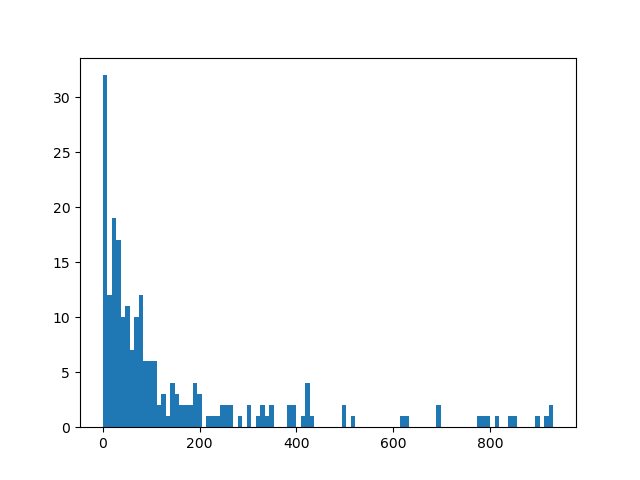

In [22]:
plt.figure()
amount_of_corners = np.array([len(a) for a in streetcorner_dict.values()])
_ = plt.hist(amount_of_corners, bins=100)
print(np.count_nonzero(amount_of_corners <= 10))

In [23]:
corners     = gpd.read_file(r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\OSM_Roads\TexasRoads_filtered_strict_3857_nondupe_smaller_harris.gpkg")
roads_gdf   = gpd.read_file(r"C:\Users\fhacesga\Downloads\TexasRoads_filtered_strict_3857.gpkg", engine='pyogrio', use_arrow=True)

In [24]:
corner_dir = os.path.join(get_largest_subdirectory(os.path.join(proc_dir, "street_corners")), "pickles")

if os.path.isdir(os.path.join(proc_dir, "focus")):
    referencing_dir  =  os.path.join(proc_dir, "focus") + "\\"
    print(f"Focus found, using {referencing_dir}")

registration_dir = os.path.join(proc_dir, "registration")
os.makedirs(registration_dir, exist_ok=True)

descriptor_kwds = {
    # "angle_step"        : 18,
    "angle_step"        : 25,
    # "azimuth_radius"    : [50, 100, 500]
    "azimuth_radius"    : [50, 100, 250, 500, 1000, 1500, 2000, 2500]
}

print(corner_dir)

Focus found, using D:\RECTDNN\processing\2025-01-21_17-30-34\\focus\
D:\RECTDNN\processing\2025-01-21_17-30-34\\street_corners\exp\pickles


In [25]:
np.set_printoptions(precision=8) 

In [26]:
def normCoords(A, B):
    offsets = np.min(A, axis=0)
    return A - offsets, B - offsets

def updateResults(list1, list2, compare_idx=8):
    combined_dict = {}
    
    # Add elements from list1, prioritizing these tuples initially
    for tup in list1:
        key = (tup[0], tup[1])  # A and B are used as the key
        if key not in combined_dict:
            combined_dict[key] = tup
    
    # Add or update elements from list2
    for tup in list2:
        key = (tup[0], tup[1])  # A and B are used as the key
        # Replace the tuple if the key exists and G in list2's tuple is greater
        
        if key in combined_dict:
            print_val = combined_dict[key][compare_idx][0]
        else:
            print_val = None
        # print(key, key in combined_dict, tup[compare_idx][0], print_val)
        if key not in combined_dict:
            combined_dict[key] = tup
        elif key in combined_dict and tup[compare_idx][0] > combined_dict[key][compare_idx][0]:
            combined_dict[key] = tup
                
    # Convert the dictionary back to a list
    combined_list = list(combined_dict.values())

    print(len(list1), len(list2), len(combined_list))
    return combined_list

def most_popular_indices(values, eps=0.1):
    # RETURN TO featurematching.py
    # Convert values to a 2D array as required by DBSCAN
    values_2d = np.array(values).reshape(-1, 1)
    
    # Cluster the values using DBSCAN
    db = DBSCAN(eps=eps, min_samples=2).fit(values_2d)
    
    # Find the most common cluster label, ignoring noise (-1 label)
    labels, counts = np.unique(db.labels_[db.labels_ != -1], return_counts=True)
    if len(counts) == 0:
        return []  # No clusters found

    most_common_label = labels[np.argmax(counts)]
    
    # Get indices of values in the most common cluster
    indices = [i for i, label in enumerate(db.labels_) if label == most_common_label]
    
    return indices

def most_popular_indices_2d(points, eps=0.1):
    # Convert the list of 2D points to a numpy array
    points_array = np.array(points)
    
    # Cluster the points using DBSCAN
    db = DBSCAN(eps=eps, min_samples=2).fit(points_array)
    
    # Find the most common cluster label, ignoring noise (-1 label)
    labels, counts = np.unique(db.labels_[db.labels_ != -1], return_counts=True)
    if len(counts) == 0:
        return []  # No clusters found
    
    print("THESE ARE THE DBSCAN COUNTS")
    print(counts)
    
    most_common_label = labels[np.argmax(counts)]
    
    # Get indices of points in the most common cluster
    indices = [i for i, label in enumerate(db.labels_) if label == most_common_label]
    
    return indices


def adjustFromMatchingV2(matchresults, corners_curr=None, idx=None, im_corner_gdf=None, plot=False, verbose=False, dbscan_eps=0.04, logging_dir=None, filter_topn=None):

    if filter_topn is not None:
        print(f"Filtering top {filter_topn}")
        conf = [a[8][0] / a[8][1] for a in matchresults]
        indices = np.argsort(conf)[:filter_topn]
        matchresults = [matchresults[a] for a in indices]

    if idx is None:
        idx = np.arange(len(matchresults), dtype=np.int32)
    
    fromPoints = gpd.GeoDataFrame(geometry=gpd.points_from_xy([x[4][0] for x in matchresults], [x[4][1] for x in matchresults]))
    toPoints   = gpd.GeoDataFrame(geometry=gpd.points_from_xy([x[5][0] for x in matchresults], [x[5][1] for x in matchresults]))

    coordsA = getCoordsGDF(fromPoints)
    coordsB = getCoordsGDF(toPoints)

    i = 0

    checker = True
    prev = np.where(idx)[0].shape[0]

    if logging_dir is not None:
        fig, axs, _, _ = plotMatches(fromPoints, toPoints, dbscan_eps=dbscan_eps)
        fig.savefig(logging_dir)
        if not plot:
            plt.close(fig)
        else:
            plt.show()
    
    while checker and i < 2:
        
        initial = affineTransformation(coordsA[idx, 0], coordsA[idx, 1], coordsB[idx, 0], coordsB[idx, 1],verbose=False, )
        matrix = initial.matrix        
        coordsBprime = np.hstack((coordsB[idx], np.ones((coordsB[idx].shape[0], 1)))) @ np.linalg.inv(matrix).T
        distances = np.sqrt((coordsBprime[:, 0] - coordsA[idx, 0]) ** 2 + (coordsBprime[:, 1] - coordsA[idx, 1]) ** 2)
        uv = coordsB - coordsA
        angles = np.degrees(np.arctan2(uv[:, 1], uv[:, 0]))
        test = np.vstack((normArry(angles), normArry(np.sqrt(uv[:, 0] ** 2, uv[:, 1] ** 2 )))).T
        test[np.isnan(test)] = 0
        db_idx = most_popular_indices_2d(test, eps=dbscan_eps)

        dist_idx = np.where(distances <= 3 * np.median(distances))[0]
        idx = np.intersect1d(idx, dist_idx, db_idx)

        print(idx.shape, dist_idx.shape, len(db_idx), np.median(distances))
        

        counter = 0
        if np.where(idx)[0].shape[0] < 10:
            print("Loosening, under 10... ", end=" ")
            while np.where(idx)[0].shape[0] < 10:
                counter = counter + 1
                idx = most_popular_indices_2d(test, eps=dbscan_eps + 0.02 * counter)
                if counter > 10:
                    break
            print(f"Loosened {counter} times at {dbscan_eps + 0.02 * counter}")
        
        if np.where(idx)[0].shape[0] < prev:
            prev = np.where(idx)[0].shape[0]
        else: 
            checker = False
        
        if verbose:
            print(i)
            print(np.linalg.inv(matrix).T)
            fig, axs = plt.subplots(1, 2)
            axs[0].scatter(coordsA[idx, 0], coordsA[idx, 1], color='black')
            axs[0].scatter(coordsB[idx, 0], coordsB[idx, 1])
            axs[0].scatter(coordsBprime[:, 0], coordsBprime[:, 1], marker='x')
            axs[1].hist(distances[idx], bins=50)
            axs[1].set_title(f"Iteration {i}")
            fig.savefig(logging_dir[:-3] + f"internalremovals_iteration{i}.jpg")
            if not plot:
                plt.close(fig)
            else:
                plt.show()

        i = i + 1

    return matrix, distances[idx], idx

def registerImagesV2(ra, im_corner_gdf, corners_curr, corner_arry, descriptor_kwds, 
                     r_initial=500, 
                     verbose=1, 
                     distance_threshold=10,
                     n_iters=20,
                     r_change=0.6,
                     dbscan_ini=0.04,
                     logging_dir=None,
                     remove_stdev=True
                     ):
    compoundedAdjustment = np.eye(3)
    flip=np.array([
        [1, 0, 0],
        [0, -1, 0],
        [0, 0, 1]
        ]) 
    
    os.makedirs(logging_dir, exist_ok=True)
    logging_basename = os.path.join(logging_dir, os.path.basename(ra.files[0]).split(".")[0])

    logging_struct = {}

    matching_results = None
    im_corner_gdf_adj = im_corner_gdf.copy()

    registration_struct = {}
    registration_struct['best_grade']       = 1e9
    registration_struct['best_transform']   = None
    registration_struct['grades']           = []
    registration_struct['transforms']       = []
    registration_struct['points']           = []


    for i in range(n_iters):

        logging_struct[i] = {}
        
        # r_current = r_initial * 0.95 ** i
        r_current = r_initial * r_change ** i
        dbscan_curr = dbscan_ini + dbscan_ini * i
            
        matching_results_curr, _, _ = matching_distances_loosen_distance(im_corner_gdf_adj, corners_curr, ratio_threshold=0.8, 
                                                                    match_radius=r_current, 
                                                                    num_retries=10,
                                                                    loosening_factor=0.25, 
                                                                    **descriptor_kwds)
        
        if matching_results is None:
            matching_results = matching_results_curr
        else:
            print("UPDATING RESULTS", print(len(matching_results)))
            matching_results = updateResults(matching_results, matching_results_curr)
            print(len(matching_results))
        
        if len(matching_results) < 3:
            raise(Exception(f"Cannot match: {len(matching_results)} matches found for {os.path.basename(ra.files[0])}"))
        
        matrix, distances, idx = adjustFromMatchingV2(matching_results, plot=verbose>8, 
                                                        dbscan_eps=dbscan_curr,
                                                        verbose=verbose>8,
                                                        # filter_topn=100,
                                                        logging_dir=None if logging_dir is None else logging_basename + f"_iteration{str(i).zfill(2)}.jpg")
        
        matching_results = [matching_results[i] for i in idx]

        print(len(matching_results))

        logging_struct[i]["matching_results"]   = matching_results
        logging_struct[i]["distances"]          = distances

        current_adjustment      = np.linalg.inv(matrix) @ getMatrixFromAffine(ra.transform)

        reprojectedcorners = np.hstack((corner_arry, np.ones((corner_arry.shape[0], 1)))) @ current_adjustment.T

        scale       = np.sqrt(0.5 * (matrix[0,0] ** 2 + matrix[1,1] ** 2))
        translation = np.sqrt(matrix[0,2] ** 2 + matrix[1,2] ** 2)
        conv_check  = np.abs(1 - scale) < 0.002 and translation < distance_threshold

        if verbose > 3:
            print(f"Scale {scale:.3e}")
            print(f"Translation {translation:.3e}")
            print(conv_check)
            print(np.linalg.inv(matrix))
            print("Inverse")
            print(np.linalg.inv(np.linalg.inv(matrix)))

        if verbose > 5:
            fig, ax  = plt.subplots()
            ax.scatter(reprojectedcorners[:, 0], reprojectedcorners[:, 1], label="Reprojected Corners")

            original_image_corners = np.hstack((corner_arry, np.ones((corner_arry.shape[0], 1)))) @  getMatrixFromAffine(ra.transform).T
            ax.scatter(original_image_corners[:, 0], original_image_corners[:, 1], label="Original Image Corners")

            # READ MATCHING RESULTS AND GET DATABASE (TARGET?)
            db_corners_x = np.array([m[5][0] for m in matching_results])
            db_corners_y = np.array([m[5][1] for m in matching_results])
            ax.scatter(db_corners_x, db_corners_y, label="Matching - Image Corners")

            # READ MATCHING RESULTS AND GET DETECTIONS (REFERENCE?)
            r_corners_x = np.array([m[4][0] for m in matching_results])
            r_corners_y = np.array([m[4][1] for m in matching_results])
            ax.scatter(r_corners_x, r_corners_y, label="Matching - Database Corners")

            ax, _ = calcQuiver(ax, 
                       gpd.GeoDataFrame(geometry=gpd.points_from_xy(db_corners_x, db_corners_y)),
                       gpd.GeoDataFrame(geometry=gpd.points_from_xy(r_corners_x, r_corners_y)), )

            try:
                cx.add_basemap(ax, zoom_adjust=1)
            except:
                print("Error adding basemap")
            ax.legend()
            plt.show()

        im_corner_gdf_adj['geometry'] = gpd.points_from_xy(reprojectedcorners[:,0], reprojectedcorners[:, 1])

        if verbose > 0:
            print(np.nanpercentile(distances, [0, 25, 50, 75, 100]), len(matching_results))

        # CHECK IF WE HAVE CORRECT DISTANCE
        matched_check = np.nanpercentile(distances, 50) < distance_threshold # and distances.shape[0] > 10

        # IF BEST, SAVE AS BEST
        if np.nanpercentile(distances, 50) < registration_struct['best_grade']:
            registration_struct['best_grade']       = np.nanpercentile(distances, 50)
            registration_struct['best_transform']   = current_adjustment
            registration_struct['best_im_corner_gdf_adj']    = im_corner_gdf_adj

        # SAVE CURRENT TIMESTEP VALUES
        registration_struct[i] = {}
        registration_struct[i]['grade']     = np.nanpercentile(distances, 50)
        registration_struct[i]['transform'] = current_adjustment
        registration_struct[i]['im_corner_gdf_adj'] = im_corner_gdf_adj

        if (matched_check or conv_check) and i > 1:
            print(matched_check, conv_check)
            break

    logging_struct['registration_struct'] = registration_struct
    with open(logging_basename+".pkl", 'wb') as handle:
        pickle.dump(logging_struct, handle, protocol=pickle.HIGHEST_PROTOCOL)       

    return registration_struct['best_transform'] , registration_struct['best_im_corner_gdf_adj']


In [52]:
def most_popular_indices_2d_v1(points, eps=0.1, auto_include=10):
    # Convert the list of 2D points to a numpy array
    points_array = np.array(points)
    
    # Cluster the points using DBSCAN
    db = DBSCAN(eps=eps, min_samples=2).fit(points_array)
    
    # Find the most common cluster label, ignoring noise (-1 label)
    labels, counts = np.unique(db.labels_[db.labels_ != -1], return_counts=True)
    if len(counts) == 0:
        return []  # No clusters found
    
    print("THESE ARE THE DBSCAN COUNTS")
    print(counts)

    goodlabels = [a for a in labels[np.max(counts) == counts]]
    goodlabels.extend([a for a in labels[counts > auto_include]])
    
    # Get indices of points in the most common cluster
    indices = [i for i, label in enumerate(db.labels_) if label in goodlabels]

    return indices

def plotMatches(fromPoints, toPoints, dbscan_eps=0.04):
    fig, axs = plt.subplots(1, 2, figsize=(15,5))

    fromPoints.plot(ax=axs[0])
    toPoints.plot(ax=axs[0])
    axs[0], uv = calcQuiver(axs[0], fromPoints, toPoints, color="black")

    try:
        cx.add_basemap(axs[0])
    except:
        print("Error adding Basemap")

    angles = np.degrees(np.arctan2(uv[:, 1], uv[:, 0]))
    angle_mean = np.nanmean(angles)
    angles = angles - angle_mean
    test = np.vstack((normArry(angles), normArry(np.sqrt(uv[:, 0] ** 2, uv[:, 1] ** 2 )))).T
    idx = most_popular_indices_2d_v1(test, eps=dbscan_eps)

    axs[0], uv = calcQuiver(axs[0], fromPoints.iloc[idx], toPoints.iloc[idx], color="yellow")

    bins = np.linspace(-180, 180, 100)

    axs[1].hist(angles + angle_mean, bins, label="All")
    axs[1].hist(angles[idx] + angle_mean, bins, label="Selected")
    axs[1].set_xlabel("Adjustment Bearing")
    axs[1].set_ylabel("Frequency (n)")

    return fig, axs, uv, idx


def adjustFromMatchingV3(matchresults, corners_curr=None, idx=None, im_corner_gdf=None, plot=False, verbose=False, dbscan_eps=0.04, logging_dir=None, filter_topn=None, distance_thresh=None):

    if filter_topn is not None:
        print(f"Filtering top {filter_topn}")
        conf = [a[8][0] / a[8][1] for a in matchresults]
        indices = np.argsort(conf)[:filter_topn]
        matchresults = [matchresults[a] for a in indices]

    if idx is None:
        idx = np.arange(len(matchresults), dtype=np.int32)
    
    fromPoints = gpd.GeoDataFrame(geometry=gpd.points_from_xy([x[4][0] for x in matchresults], [x[4][1] for x in matchresults]))
    toPoints   = gpd.GeoDataFrame(geometry=gpd.points_from_xy([x[5][0] for x in matchresults], [x[5][1] for x in matchresults]))

    coordsA = getCoordsGDF(fromPoints)
    coordsB = getCoordsGDF(toPoints)

    i = 0

    checker = True
    prev = np.where(idx)[0].shape[0]

    if logging_dir is not None:
        fig, axs, _, _ = plotMatches(fromPoints, toPoints, dbscan_eps=dbscan_eps)
        fig.savefig(logging_dir)
        if not plot:
            plt.close(fig)
        else:
            plt.show()
    
    while checker and i < 2:
        
        initial = similarityTransformation(coordsA[idx, 0], coordsA[idx, 1], coordsB[idx, 0], coordsB[idx, 1],verbose=False, )
        matrix = initial.matrix        
        coordsBprime = np.hstack((coordsB[idx], np.ones((coordsB[idx].shape[0], 1)))) @ np.linalg.inv(matrix).T
        distances = np.sqrt((coordsBprime[:, 0] - coordsA[idx, 0]) ** 2 + (coordsBprime[:, 1] - coordsA[idx, 1]) ** 2)
        uv = coordsB - coordsA
        angles = np.degrees(np.arctan2(uv[:, 1], uv[:, 0]))
        test = np.vstack((normArry(angles), normArry(np.sqrt(uv[:, 0] ** 2, uv[:, 1] ** 2 )))).T
        test[np.isnan(test)] = 0
        db_idx = most_popular_indices_2d_v1(test, eps=dbscan_eps)

        dist_idx = np.where(distances <= 3 * np.median(distances))[0]
        idx = np.intersect1d(idx, dist_idx, db_idx)

        print(idx.shape, dist_idx.shape, len(db_idx), np.median(distances))
        

        counter = 0
        if np.where(idx)[0].shape[0] < 10:
            print("Loosening, under 10... ", end=" ")
            while np.where(idx)[0].shape[0] < 10:
                counter = counter + 1
                idx = most_popular_indices_2d_v1(test, eps=dbscan_eps + 0.02 * counter)
                if counter > 10:
                    break
            print(f"Loosened {counter} times at {dbscan_eps + 0.02 * counter}")
        
        if np.where(idx)[0].shape[0] < prev:
            prev = np.where(idx)[0].shape[0]
        else: 
            checker = False
        
        if verbose:
            print(i)
            print(np.linalg.inv(matrix).T)
            fig, axs = plt.subplots(1, 2)
            axs[0].scatter(coordsA[idx, 0], coordsA[idx, 1], color='black')
            axs[0].scatter(coordsB[idx, 0], coordsB[idx, 1])
            axs[0].scatter(coordsBprime[:, 0], coordsBprime[:, 1], marker='x')
            axs[1].hist(distances[idx], bins=50)
            axs[1].set_title(f"Iteration {i}")
            fig.savefig(logging_dir[:-3] + f"internalremovals_iteration{i}.jpg")
            if not plot:
                plt.close(fig)
            else:
                plt.show()

        i = i + 1

    

    if distance_thresh is not None:
        print("APPLYING DISTANCE THRESHOLD")
        print(distances.shape)
        # print(distances)
        distances = distances[idx]
        # print(distances)
        # print(idx)
        idx = idx[distances < distance_thresh]
        # print(idx)
        print(distances.shape)
        distances = distances[distances < distance_thresh]
        
    else:
        distances = distances[idx]

    return matrix, distances, idx


def registerImagesV2_group(group_name, im_corner_gdf, corners_curr, corner_arry, descriptor_kwds, 
                     r_initial=500, 
                     verbose=1, 
                     distance_threshold=10,
                     n_iters=20,
                     r_change=0.6,
                     dbscan_ini=0.04,
                     dbscan_max=0.1,
                     logging_dir=None,
                     remove_stdev=True
                     ):
    compoundedAdjustment = np.eye(3)
    flip=np.array([
        [1, 0, 0],
        [0, -1, 0],
        [0, 0, 1]
        ]) 
    
    os.makedirs(logging_dir, exist_ok=True)
    logging_basename = os.path.join(logging_dir, group_name)

    logging_struct = {}

    matching_results = None
    im_corner_gdf_adj = im_corner_gdf.copy()

    registration_struct = {}
    registration_struct['best_grade']       = 1e9
    registration_struct['best_transform']   = None
    registration_struct['grades']           = []
    registration_struct['transforms']       = []
    registration_struct['points']           = []

    for i in range(n_iters):

        logging_struct[i] = {}
        
        # r_current = r_initial * 0.95 ** i
        r_current = r_initial * r_change ** i
        dbscan_curr = dbscan_ini + dbscan_ini * i
        if dbscan_curr > dbscan_max:
            dbscan_max = dbscan_curr
            
        matching_results_curr, _, _ = matching_distances_loosen_distance(im_corner_gdf_adj, corners_curr, ratio_threshold=0.75, 
                                                                    match_radius=r_current, 
                                                                    num_retries=10,
                                                                    loosening_factor=0.25, 
                                                                    **descriptor_kwds)
        
        if matching_results is None:
            matching_results = matching_results_curr
        else:
            print("UPDATING RESULTS", len(matching_results))
            matching_results = updateResults(matching_results, matching_results_curr)
            print(len(matching_results))
        
        if len(matching_results) < 3:
            raise(Exception(f"Cannot match: {len(matching_results)} matches found for {os.path.basename(ra.files[0])}"))
        
        matrix, distances, idx = adjustFromMatchingV3(matching_results, plot=verbose>8, 
                                                        dbscan_eps=dbscan_curr,
                                                        verbose=verbose>8,
                                                        # filter_topn=500,
                                                        distance_thresh=r_current,
                                                        logging_dir=None if logging_dir is None else logging_basename + f"_iteration{str(i).zfill(2)}.jpg")
        
        matching_results = [matching_results[i] for i in idx]

        print(len(matching_results))

        logging_struct[i]["matching_results"]   = matching_results
        logging_struct[i]["distances"]          = distances

        # current_transformation  = np.linalg.inv(matrix) @ getMatrixFromAffine(ra.transform)
        current_adjustment      = np.linalg.inv(matrix)

        # reprojectedcorners = np.hstack((corner_arry, np.ones((corner_arry.shape[0], 1)))) @ current_transformation.T

        scale       = np.sqrt(0.5 * (matrix[0,0] ** 2 + matrix[1,1] ** 2))
        translation = np.sqrt(matrix[0,2] ** 2 + matrix[1,2] ** 2)
        conv_check  = np.abs(1 - scale) < 0.002 and translation < distance_threshold

        if verbose > 3:
            print(f"Scale {scale:.3e}")
            print(f"Translation {translation:.3e}")
            print(conv_check)
            print(np.linalg.inv(matrix))
            print("Inverse")
            print(np.linalg.inv(np.linalg.inv(matrix)))

        if verbose > 5:
            fig, ax  = plt.subplots()
            # ax.scatter(reprojectedcorners[:, 0], reprojectedcorners[:, 1], label="Reprojected Corners")

            # original_image_corners = np.hstack((corner_arry, np.ones((corner_arry.shape[0], 1)))) @  getMatrixFromAffine(ra.transform).T
            # ax.scatter(original_image_corners[:, 0], original_image_corners[:, 1], label="Original Image Corners")

            # READ MATCHING RESULTS AND GET DATABASE (TARGET?)
            db_corners_x = np.array([m[5][0] for m in matching_results])
            db_corners_y = np.array([m[5][1] for m in matching_results])
            ax.scatter(db_corners_x, db_corners_y, label="Matching - Image Corners")

            # READ MATCHING RESULTS AND GET DETECTIONS (REFERENCE?)
            r_corners_x = np.array([m[4][0] for m in matching_results])
            r_corners_y = np.array([m[4][1] for m in matching_results])
            ax.scatter(r_corners_x, r_corners_y, label="Matching - Database Corners")

            ax, _ = calcQuiver(ax, 
                       gpd.GeoDataFrame(geometry=gpd.points_from_xy(db_corners_x, db_corners_y)),
                       gpd.GeoDataFrame(geometry=gpd.points_from_xy(r_corners_x, r_corners_y)), )

            try:
                cx.add_basemap(ax, zoom_adjust=1)
            except:
                print("Error adding basemap")
            ax.legend()
            plt.show()

        # im_corner_gdf_adj['geometry'] = gpd.points_from_xy(reprojectedcorners[:,0], reprojectedcorners[:, 1])

        if verbose > 0:
            print(np.nanpercentile(distances, [0, 25, 50, 75, 100]), len(matching_results))
            print(f"Distances under 100: {distances[distances<100]}" )

        # CHECK IF WE HAVE CORRECT DISTANCE
        matched_check = np.nanpercentile(distances, 50) < distance_threshold # and distances.shape[0] > 10

        # IF BEST, SAVE AS BEST
        if np.nanpercentile(distances, 50) < registration_struct['best_grade']:
            registration_struct['best_grade']       = np.nanpercentile(distances, 50)
            # registration_struct['best_transform']   = current_transformation
            registration_struct['best_adjustment'] = current_adjustment
            # registration_struct['best_im_corner_gdf_adj']    = im_corner_gdf_adj

        # SAVE CURRENT TIMESTEP VALUES
        registration_struct[i] = {}
        registration_struct[i]['grade']     = np.nanpercentile(distances, 50)
        # registration_struct[i]['transform'] = current_transformation
        registration_struct[i]['adjust'] = current_adjustment
        # registration_struct[i]['im_corner_gdf_adj'] = im_corner_gdf_adj

        if (matched_check or conv_check) and i > 1:
            print(matched_check, conv_check)
            break

    logging_struct['registration_struct'] = registration_struct
    with open(logging_basename+".pkl", 'wb') as handle:
        pickle.dump(logging_struct, handle, protocol=pickle.HIGHEST_PROTOCOL)       

    # return registration_struct['best_transform'] , registration_struct['best_im_corner_gdf_adj'], registration_struct['best_adjustment']
    return registration_struct['best_transform'] , None, registration_struct['best_adjustment']


In [55]:
register_tile_names = glob.glob(referencing_dir + "*")

flip=np.array([
    [1, 0, 0],
    [0, -1, 0],
    [0, 0, 1]
    ]) 

def getTileCorners(tile_dir, ra_ref, conf_thresh=0.3):

    tile_name = os.path.basename(tile_dir).split(".")[0]

    with open(f"{corner_dir}/{tile_name}.pickle", 'rb') as f:
        x = pickle.load(f)    
        corner_bbox = [a.bbox.to_xyxy() for a in x if a.score.value > conf_thresh]
        corner_arry = np.array([calcCenter(a) for a in corner_bbox ]) * 2
        print(f"{len(corner_bbox)} / {len(x)}")

    corner_arry = np.int32(corner_arry)                # CONVERT TO INT32
    corner_arry = cleanCenterBBOX(corner_arry, bbox)

    # USE RASTER TRANSFORM TO GET REAL-WORLD ESTIMATES OF STREET CORNERS
    im_corner_gdf = pointsToGeodataFrame(ra_ref, corner_arry[:, 1], corner_arry[:, 0])
    return im_corner_gdf


for curr_dir in register_tile_names:
    
    ra_ref = []
    im_corner_list = []
    tile_dirs = []

    if os.path.isdir(curr_dir):
        print("FOUND GROUPING - USING")
        curr_tile_names = glob.glob(curr_dir + "/*.tif")
        for tile_dir in curr_tile_names:
            curr_ra_ref = rio.open(tile_dir)
            curr_im_corner_gdf = getTileCorners(tile_dir, curr_ra_ref)
            tile_dirs.append(tile_dir)
            ra_ref.append(curr_ra_ref)
            im_corner_list.append(curr_im_corner_gdf)

    else:
        print("FOUND GROUPING - USING")
        curr_ra_ref = rio.open(curr_dir)
        curr_im_corner_gdf = getTileCorners(curr_dir, curr_ra_ref)
        ra_ref.append(curr_ra_ref)
        im_corner_list.append(curr_im_corner_gdf)
        tile_dirs.append(tile_dir)

    # CONVERT LIST TO GEODATAFRAME
    im_corner_gdf   = gpd.GeoDataFrame(pd.concat(im_corner_list))
    corner_arry     = np.stack(im_corner_gdf.geometry.apply(lambda point: np.array([point.x, point.y])))

    # BOUNDS
    bounds_poly     = enlarged_bounds(ra_ref, n=1.2)
    corners_curr    = gpd.clip(corners, bounds_poly)
    
    current_transform_mymethod, im_corner_gdf_adj, best_adjustment = registerImagesV2_group("test1", im_corner_gdf, corners_curr, corner_arry, descriptor_kwds,
                                        distance_threshold=5,
                                        n_iters=50,
                                        r_initial=3500, 
                                        r_change=0.95, # 0.99,# 0.95, # 0.8,# 0.995,
                                        dbscan_ini=0.02,
                                        dbscan_max=0.1,
                                        verbose=5, logging_dir=f"{registration_dir}/logs/")
    
    # icp_transform, transform_dict = performWeightedICPonTile([im_corner_gdf_adj], [corners_curr], proc_limit=5000, 
    #                                                       icp_iterations=100, plot_datasets=[corners_curr], weights=[1, 1/10], 
    #                                                       plot=True, shear=True, dist_threshold=100)
    
    # current_adjustment = icp_transform @ np.linalg.inv(best_adjustment)
    
    for i, tile_dir in enumerate(tile_dirs):

        image = cv2.imread(tile_dir)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        tile_name = os.path.basename(tile_dir).split(".")[0]
        print(f"{registration_dir}/{tile_name}.tif")

        current_adjustment_mymethod = np.linalg.inv(best_adjustment) @ getMatrixFromAffine(ra_ref[i].transform)

        try:
            with rio.open(f"{registration_dir}/{tile_name}.tif", 'w',
                        driver='GTiff', count=1, dtype=np.uint8,
                        height=image.shape[0], width=image.shape[1],
                        crs=f'EPSG:3857',
                        # compress= 'CCITTFAX4',  # Use CCITTFAX4 or CCITTRLE for binary data compression
                        transform=rio.Affine(*current_adjustment_mymethod.flatten()[:6])) as dst:
                            dst.write(image, 1) 
        except Exception as e:
            print(e)
            traceback.print_exc()
        
        """
        try:
            with rio.open(f"{registration_dir}/{tile_name}_icp.tif", 'w',
                        driver='GTiff', count=1, dtype=np.uint8,
                        height=image.shape[0], width=image.shape[1],
                        crs=f'EPSG:3857',
                        # compress= 'CCITTFAX4',  # Use CCITTFAX4 or CCITTRLE for binary data compression
                        transform=rio.Affine(*current_adjustment.flatten()[:6])) as dst:
                            dst.write(image, 1) 
        except Exception as e:
                print(e)
                traceback.print_exc()"""
    
    for r in ra_ref:
        r.close()
    error

FOUND GROUPING - USING
2 / 65
37 / 551
25 / 362
81 / 434
21 / 287
17 / 269
84 / 431
24 / 222
30 / 252


  0%|          | 0/21475 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

THESE ARE THE DBSCAN COUNTS
[4 3 2 4 2 3]
THESE ARE THE DBSCAN COUNTS
[4 3 2 4 2 3]
(58,) (58,) 8 2670.834415679236
APPLYING DISTANCE THRESHOLD
(58,)
(58,)
44
Scale 8.605e-01
Translation 1.672e+06
False
[[ 1.15781184e+00  7.08191101e-02  1.43320607e+06]
 [-7.08191101e-02  1.15781184e+00 -1.30710223e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 8.60478869e-01 -5.26323410e-02 -1.30203939e+06]
 [ 5.26323410e-02  8.60478869e-01  1.04930086e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 731.49722638 1735.1956077  2392.47221244 2774.73403839 3490.5122918 ] 44
Distances under 100: []


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 44
44 48 59
59
THESE ARE THE DBSCAN COUNTS
[2 2 4 4 5 2 2 4 2 6]
THESE ARE THE DBSCAN COUNTS
[2 2 4 4 5 2 2 4 2 6]
(59,) (59,) 6 2383.3831593407563
APPLYING DISTANCE THRESHOLD
(59,)
(59,)
41
Scale 8.497e-01
Translation 1.813e+06
False
[[ 1.17114654e+00  8.19446502e-02  1.53659416e+06]
 [-8.19446502e-02  1.17114654e+00 -1.47244516e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 8.49704179e-01 -5.94534583e-02 -1.39319243e+06]
 [ 5.94534583e-02  8.49704179e-01  1.15978697e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 701.38104232 1595.51040843 2125.28229163 2410.89397767 2933.31329037] 41
Distances under 100: []


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 41
41 39 56
56
THESE ARE THE DBSCAN COUNTS
[2 2 8 3 3 5 3 2 2 4 4 2]
THESE ARE THE DBSCAN COUNTS
[2 2 8 3 3 5 3 2 2 4 4 2]
(56,) (56,) 8 2314.387827644485
APPLYING DISTANCE THRESHOLD
(56,)
(56,)
43
Scale 8.533e-01
Translation 1.804e+06
False
[[ 1.16501646e+00  8.99556413e-02  1.44333251e+06]
 [-8.99556413e-02  1.16501646e+00 -1.53647068e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 8.53269768e-01 -6.58844160e-02 -1.33278147e+06]
 [ 6.58844160e-02  8.53269768e-01  1.21593086e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 681.61595375 1648.37820102 2122.0072863  2417.94099332 2840.60437098] 43
Distances under 100: []


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 43
43 35 60
60
THESE ARE THE DBSCAN COUNTS
[16 13  6  2  4  2  2  3]
THESE ARE THE DBSCAN COUNTS
[16 13  6  2  4  2  2  3]
(60,) (60,) 29 2345.098984424723
APPLYING DISTANCE THRESHOLD
(60,)
(60,)
44
Scale 8.475e-01
Translation 1.822e+06
False
[[ 1.17475153e+00  7.78519449e-02  1.58913281e+06]
 [-7.78519449e-02  1.17475153e+00 -1.44159368e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 8.47521652e-01 -5.61660973e-02 -1.42779316e+06]
 [ 5.61660973e-02  8.47521652e-01  1.13252647e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 633.30119107 1649.74532658 2107.41995265 2405.77237683 2913.23759967] 44
Distances under 100: []


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 44
44 34 66
66
THESE ARE THE DBSCAN COUNTS
[15 21  6  2  4  2  2  2  2]
THESE ARE THE DBSCAN COUNTS
[15 21  6  2  4  2  2  2  2]
(66,) (66,) 36 2243.152038924644
APPLYING DISTANCE THRESHOLD
(66,)
(66,)
52
Scale 8.533e-01
Translation 1.785e+06
False
[[ 1.16586130e+00  8.43021376e-02  1.47189712e+06]
 [-8.43021376e-02  1.16586130e+00 -1.47915685e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 8.53273560e-01 -6.16992650e-02 -1.34719379e+06]
 [ 6.16992650e-02  8.53273560e-01  1.17131046e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 591.75324278 1644.29654077 2096.52852403 2368.05337481 2847.24050874] 52
Distances under 100: []


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 52
52 29 68
68
THESE ARE THE DBSCAN COUNTS
[21 19  6  4  4  7]
THESE ARE THE DBSCAN COUNTS
[21 19  6  4  4  7]
(68,) (68,) 40 2132.5148453239867
APPLYING DISTANCE THRESHOLD
(68,)
(68,)
52
Scale 8.645e-01
Translation 1.720e+06
False
[[ 1.14883043e+00  9.53431056e-02  1.25195935e+06]
 [-9.53431056e-02  1.14883043e+00 -1.53735088e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 8.64496190e-01 -7.17457939e-02 -1.19261255e+06]
 [ 7.17457939e-02  8.64496190e-01  1.23921116e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 249.59410047 1521.21561646 1950.17008605 2279.06385102 2626.67677665] 52
Distances under 100: []


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 52
52 31 70
70
THESE ARE THE DBSCAN COUNTS
[46  7  2  4  6  2]
THESE ARE THE DBSCAN COUNTS
[46  7  2  4  6  2]
(70,) (70,) 46 2085.669550017601
APPLYING DISTANCE THRESHOLD
(70,)
(70,)
54
Scale 8.631e-01
Translation 1.721e+06
False
[[ 1.15123227e+00  9.22708304e-02  1.28809931e+06]
 [-9.22708304e-02  1.15123227e+00 -1.51309092e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 8.63089983e-01 -6.91763351e-02 -1.21641570e+06]
 [ 6.91763351e-02  8.63089983e-01  1.21682763e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 499.35381965 1258.20122502 1973.42553334 2177.32739684 2555.35840243] 54
Distances under 100: []


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 54
54 23 69
69
THESE ARE THE DBSCAN COUNTS
[46  8  2  8  5]
THESE ARE THE DBSCAN COUNTS
[46  8  2  8  5]
(69,) (69,) 46 1998.3257709730624
APPLYING DISTANCE THRESHOLD
(69,)
(69,)
52
Scale 8.714e-01
Translation 1.678e+06
False
[[ 1.13887686e+00  9.97846748e-02  1.13032216e+06]
 [-9.97846748e-02  1.13887686e+00 -1.54999564e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 8.71368822e-01 -7.63464931e-02 -1.10326423e+06]
 [ 7.63464931e-02  8.71368822e-01  1.26432175e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 219.59436254 1186.79130918 1813.65188932 2094.55882819 2417.78270644] 52
Distances under 100: []


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 52
52 20 66
66
THESE ARE THE DBSCAN COUNTS
[52  2  9  3]
THESE ARE THE DBSCAN COUNTS
[52  2  9  3]
(66,) (66,) 52 1916.8862696149295
APPLYING DISTANCE THRESHOLD
(66,)
(66,)
51
Scale 8.577e-01
Translation 1.776e+06
False
[[ 1.15826830e+00  9.38691901e-02  1.35769743e+06]
 [-9.38691901e-02  1.15826830e+00 -1.55490083e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 8.57724364e-01 -6.95122984e-02 -1.27261489e+06]
 [ 6.95122984e-02  8.57724364e-01  1.23929966e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 410.03834191 1091.26364536 1670.56917212 2104.82919492 2277.85251111] 51
Distances under 100: []


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 51
51 26 70
70
THESE ARE THE DBSCAN COUNTS
[68  2]
THESE ARE THE DBSCAN COUNTS
[68  2]
(70,) (70,) 68 1914.2761841467704
APPLYING DISTANCE THRESHOLD
(70,)
(70,)
53
Scale 8.598e-01
Translation 1.743e+06
False
[[ 1.15600147e+00  9.00176375e-02  1.34733244e+06]
 [-9.00176375e-02  1.15600147e+00 -1.50571655e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 8.59837003e-01 -6.69553611e-02 -1.25930209e+06]
 [ 6.69553611e-02  8.59837003e-01  1.20445967e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 319.88486891 1063.04810031 1654.34019503 1944.54914599 2173.9998097 ] 53
Distances under 100: []


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 53
53 26 66
66
THESE ARE THE DBSCAN COUNTS
[45  2 19]
THESE ARE THE DBSCAN COUNTS
[45  2 19]
(66,) (66,) 64 1629.327464134
APPLYING DISTANCE THRESHOLD
(66,)
(66,)
48
Scale 8.529e-01
Translation 1.761e+06
False
[[ 1.16764859e+00  7.50933087e-02  1.52371959e+06]
 [-7.50933087e-02  1.16764859e+00 -1.38726426e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 8.52894498e-01 -5.48509803e-02 -1.37566486e+06]
 [ 5.48509803e-02  8.52894498e-01  1.09961254e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 417.79590638 1143.6753669  1492.182009   1636.26867559 2016.06229285] 48
Distances under 100: []


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 48
48 23 62
62
THESE ARE THE DBSCAN COUNTS
[40  2 20]
THESE ARE THE DBSCAN COUNTS
[40  2 20]
(62,) (62,) 60 1468.9529810098038
APPLYING DISTANCE THRESHOLD
(62,)
(62,)
48
Scale 8.499e-01
Translation 1.739e+06
False
[[ 1.17418110e+00  5.33621764e-02  1.66950463e+06]
 [-5.33621764e-02  1.17418110e+00 -1.17838265e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 8.49902020e-01 -3.86248947e-02 -1.46443026e+06]
 [ 3.86248947e-02  8.49902020e-01  9.37025350e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 469.08848058 1229.4419434  1361.91835045 1491.89071285 1778.33232959] 48
Distances under 100: []


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 48
48 24 62
62
THESE ARE THE DBSCAN COUNTS
[61]
THESE ARE THE DBSCAN COUNTS
[61]
(62,) (62,) 61 1458.192776353143
APPLYING DISTANCE THRESHOLD
(62,)
(62,)
52
Scale 8.609e-01
Translation 1.605e+06
False
[[ 1.15974027e+00  4.54035835e-02  1.54346034e+06]
 [-4.54035835e-02  1.15974027e+00 -1.04296770e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 8.60942461e-01 -3.37057133e-02 -1.36398452e+06]
 [ 3.37057133e-02  8.60942461e-01  8.45911751e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 533.97046358 1182.80823237 1397.27322518 1547.16389254 1870.92289495] 52
Distances under 100: []


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 52
52 26 66
66
THESE ARE THE DBSCAN COUNTS
[65]
THESE ARE THE DBSCAN COUNTS
[65]
(66,) (66,) 65 1433.347131530264
APPLYING DISTANCE THRESHOLD
(66,)
(66,)
52
Scale 8.596e-01
Translation 1.608e+06
False
[[ 1.16194468e+00  3.92849686e-02  1.58834501e+06]
 [-3.92849686e-02  1.16194468e+00 -9.85426786e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 8.59643515e-01 -2.90642653e-02 -1.39405119e+06]
 [ 2.90642653e-02  8.59643515e-01  8.00951666e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 640.63159147 1084.65456386 1317.08253348 1517.86390972 1710.78974057] 52
Distances under 100: []


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 52
52 24 66
66
THESE ARE THE DBSCAN COUNTS
[65]
THESE ARE THE DBSCAN COUNTS
[65]
(66,) (66,) 65 1422.856460308888
APPLYING DISTANCE THRESHOLD
(66,)
(66,)
49
Scale 8.717e-01
Translation 1.461e+06
False
[[ 1.14639113e+00  2.94437395e-02  1.45701850e+06]
 [-2.94437395e-02  1.14639113e+00 -8.26183125e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 8.71727586e-01 -2.23893218e-02 -1.28862090e+06]
 [ 2.23893218e-02  8.71727586e-01  6.87584965e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 535.81341953 1150.33770386 1336.65165388 1477.4581889  1689.65055552] 49
Distances under 100: []


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 49
49 26 68
68
THESE ARE THE DBSCAN COUNTS
[68]
THESE ARE THE DBSCAN COUNTS
[68]
(68,) (68,) 68 1408.266712114636
APPLYING DISTANCE THRESHOLD
(68,)
(68,)
45
Scale 8.768e-01
Translation 1.390e+06
False
[[ 1.14028121e+00  1.71277419e-02  1.43481169e+06]
 [-1.71277419e-02  1.14028121e+00 -6.73544112e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 8.76778832e-01 -1.31697702e-02 -1.26688294e+06]
 [ 1.31697702e-02  8.76778832e-01  5.71653080e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 501.87290621 1051.89305165 1253.77435203 1408.11683058 1555.52069217] 45
Distances under 100: []


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 45
45 21 59
59
THESE ARE THE DBSCAN COUNTS
[59]
THESE ARE THE DBSCAN COUNTS
[59]
(59,) (59,) 59 1330.5462662671368
APPLYING DISTANCE THRESHOLD
(59,)
(59,)
43
Scale 8.836e-01
Translation 1.307e+06
False
[[ 1.13163703e+00  8.57252456e-03  1.37252172e+06]
 [-8.57252456e-03  1.13163703e+00 -5.51937015e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 8.83624865e-01 -6.69375043e-03 -1.21648885e+06]
 [ 6.69375043e-03  8.83624865e-01  4.78517953e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 640.55106049  990.65261852 1252.65436571 1337.78704034 1532.87835199] 43
Distances under 100: []


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 43
43 20 57
57
THESE ARE THE DBSCAN COUNTS
[57]
THESE ARE THE DBSCAN COUNTS
[57]
(57,) (57,) 57 1284.2398752389627
APPLYING DISTANCE THRESHOLD
(57,)
(57,)
42
Scale 8.791e-01
Translation 1.356e+06
False
[[ 1.13748799e+00  4.51512606e-03  1.44904090e+06]
 [-4.51512606e-03  1.13748799e+00 -5.29148713e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 8.79116307e-01 -3.48954975e-03 -1.27572197e+06]
 [ 3.48954975e-03  8.79116307e-01  4.60126762e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 532.08171087  950.3143392  1202.4698265  1291.50504718 1453.59072519] 42
Distances under 100: []


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 42
42 19 56
56
THESE ARE THE DBSCAN COUNTS
[56]
THESE ARE THE DBSCAN COUNTS
[56]
(56,) (56,) 56 1279.2384113841795
APPLYING DISTANCE THRESHOLD
(56,)
(56,)
36
Scale 8.830e-01
Translation 1.313e+06
False
[[ 1.13243566e+00  5.31158234e-03  1.39249511e+06]
 [-5.31158234e-03  1.13243566e+00 -5.19845366e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 8.83032950e-01 -4.14178252e-03 -1.23177215e+06]
 [ 4.14178252e-03  8.83032950e-01  4.53273175e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 430.09766764  893.85940671 1109.20112485 1255.78062017 1360.24169729] 36
Distances under 100: []


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 36
36 16 48
48
THESE ARE THE DBSCAN COUNTS
[48]
THESE ARE THE DBSCAN COUNTS
[48]
(48,) (48,) 48 1097.510557155275
APPLYING DISTANCE THRESHOLD
(48,)
(48,)
31
Scale 8.883e-01
Translation 1.253e+06
False
[[ 1.12579445e+00  1.64543904e-03  1.33473276e+06]
 [-1.64543904e-03  1.12579445e+00 -4.57412286e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 8.88259720e-01 -1.29826295e-03 -1.18618319e+06]
 [ 1.29826295e-03  8.88259720e-01  4.04568075e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 266.96399707  851.11606721  987.47214502 1085.43587997 1306.92419298] 31
Distances under 100: []


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 31
31 15 43
43
THESE ARE THE DBSCAN COUNTS
[43]
THESE ARE THE DBSCAN COUNTS
[43]
(43,) (43,) 43 1029.2561721885593
APPLYING DISTANCE THRESHOLD
(43,)
(43,)
28
Scale 9.042e-01
Translation 1.075e+06
False
[[ 1.10599150e+00 -2.78114169e-03  1.13937648e+06]
 [ 2.78114169e-03  1.10599150e+00 -3.40909355e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 9.04160364e-01  2.27361429e-03 -1.02940396e+06]
 [-2.27361429e-03  9.04160364e-01  3.10827229e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 223.20320106  650.91217521  899.84274506 1015.93753805 1155.53380939] 28
Distances under 100: []


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 28
28 17 40
40
THESE ARE THE DBSCAN COUNTS
[40]
THESE ARE THE DBSCAN COUNTS
[40]
(40,) (40,) 40 979.1855062511381
APPLYING DISTANCE THRESHOLD
(40,)
(40,)
26
Scale 9.155e-01
Translation 9.912e+05
False
[[ 1.09143562e+00 -3.07094279e-02  1.08219169e+06]
 [ 3.07094279e-02  1.09143562e+00  7.52352332e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 9.15499671e-01  2.57591658e-02 -9.90939936e+05]
 [-2.57591658e-02  9.15499671e-01  2.09885721e+04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 118.3479223   402.87875888  795.36878107  954.05023562 1182.50283707] 26
Distances under 100: []


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 26
26 17 41
41
THESE ARE THE DBSCAN COUNTS
[41]
THESE ARE THE DBSCAN COUNTS
[41]
(41,) (41,) 41 1033.1158999823642
APPLYING DISTANCE THRESHOLD
(41,)
(41,)
24
Scale 9.250e-01
Translation 9.034e+05
False
[[ 1.07997057e+00 -3.42437755e-02  9.72373973e+05]
 [ 3.42437755e-02  1.07997057e+00  8.52597268e+04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 9.25021141e-01  2.93306292e-02 -9.01967204e+05]
 [-2.93306292e-02  9.25021141e-01 -5.03467094e+04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 141.06264578  369.61895387  823.71030922  985.1704324  1109.67649952] 24
Distances under 100: []


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 24
24 16 38
38
THESE ARE THE DBSCAN COUNTS
[38]
THESE ARE THE DBSCAN COUNTS
[38]
(38,) (38,) 38 980.2433697206008
APPLYING DISTANCE THRESHOLD
(38,)
(38,)
22
Scale 9.264e-01
Translation 8.814e+05
False
[[ 1.07855592e+00 -3.18312618e-02  9.48860468e+05]
 [ 3.18312618e-02  1.07855592e+00  6.45316673e+04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 9.26358779e-01  2.73394899e-02 -8.80749488e+05]
 [-2.73394899e-02  9.26358779e-01 -3.38381154e+04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 134.2750028   364.15954603  754.66864964  965.74565044 1028.60018401] 22
Distances under 100: []


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 22
22 15 35
35
THESE ARE THE DBSCAN COUNTS
[35]
THESE ARE THE DBSCAN COUNTS
[35]
(35,) (35,) 35 1016.6293407962053
APPLYING DISTANCE THRESHOLD
(35,)
(35,)
18
Scale 9.337e-01
Translation 7.475e+05
False
[[ 1.07100411e+00 -7.09605452e-03  7.81736137e+05]
 [ 7.09605452e-03  1.07100411e+00 -1.72533649e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 9.33662248e-01  6.18608104e-03 -7.28810212e+05]
 [-6.18608104e-03  9.33662248e-01  1.65924038e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 206.58267565  394.40828837  626.86581702  872.67914323 1016.6293408 ] 18
Distances under 100: []


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 18
18 11 26
26
THESE ARE THE DBSCAN COUNTS
[26]
THESE ARE THE DBSCAN COUNTS
[26]
(26,) (26,) 26 884.3282387721912
APPLYING DISTANCE THRESHOLD
(26,)
(26,)
16
Scale 9.481e-01
Translation 5.909e+05
False
[[ 1.05470193e+00 -9.68764926e-03  6.17045695e+05]
 [ 9.68764926e-03  1.05470193e+00 -8.79072087e+04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 9.48055194e-01  8.70807759e-03 -5.84227873e+05]
 [-8.70807759e-03  9.48055194e-01  8.87141676e+04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[309.95735142 455.92309636 606.51572819 862.19102518 923.62162083] 16
Distances under 100: []


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 16
16 12 24
24
THESE ARE THE DBSCAN COUNTS
[24]
THESE ARE THE DBSCAN COUNTS
[24]
(24,) (24,) 24 788.9155788417427
APPLYING DISTANCE THRESHOLD
(24,)
(24,)
15
Scale 9.569e-01
Translation 4.854e+05
False
[[ 1.04498050e+00 -4.66202223e-03  4.95729722e+05]
 [ 4.66202223e-03  1.04498050e+00 -1.07440734e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 9.56936610e-01  4.26922775e-03 -4.73923231e+05]
 [-4.26922775e-03  9.56936610e-01  1.04930355e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[303.22532589 562.7670521  720.75722082 775.00045163 893.17492526] 15
Distances under 100: []


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 15
15 8 18
18
THESE ARE THE DBSCAN COUNTS
[18]
THESE ARE THE DBSCAN COUNTS
[18]
(18,) (18,) 18 741.0948041487662
APPLYING DISTANCE THRESHOLD
(18,)
(18,)
15
Scale 9.632e-01
Translation 4.147e+05
False
[[ 1.03816383e+00 -4.10307179e-03  4.21160342e+05]
 [ 4.10307179e-03  1.03816383e+00 -8.95585035e+04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 9.63224060e-01  3.80689189e-03 -4.05330835e+05]
 [-3.80689189e-03  9.63224060e-01  8.78682172e+04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[262.26375182 606.70741949 684.46753026 762.15643492 848.21922402] 15
Distances under 100: []


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 15
15 9 19
19
THESE ARE THE DBSCAN COUNTS
[19]
THESE ARE THE DBSCAN COUNTS
[19]
(19,) (19,) 19 695.884293153647
APPLYING DISTANCE THRESHOLD
(19,)
(19,)
15
Scale 9.692e-01
Translation 3.599e+05
False
[[ 1.03171663e+00 -9.44922582e-03  3.71174088e+05]
 [ 9.44922582e-03  1.03171663e+00 -1.00239862e+04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 9.69177096e-01  8.87644243e-03 -3.59644447e+05]
 [-8.87644243e-03  9.69177096e-01  1.30097233e+04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[293.18696943 556.69501011 675.32369371 732.44238231 828.12122889] 15
Distances under 100: []


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 15
15 10 19
19
THESE ARE THE DBSCAN COUNTS
[19]
THESE ARE THE DBSCAN COUNTS
[19]
(19,) (19,) 19 692.6287189605017
APPLYING DISTANCE THRESHOLD
(19,)
(19,)
11
Scale 9.727e-01
Translation 3.159e+05
False
[[ 1.02798396e+00 -7.43875444e-03  3.24271019e+05]
 [ 7.43875444e-03  1.02798396e+00 -1.84272598e+04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 9.72726892e-01  7.03890021e-03 -3.15297433e+05]
 [-7.03890021e-03  9.72726892e-01  2.02072025e+04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[233.35555158 572.65078743 634.41815537 670.19135368 745.11855814] 11
Distances under 100: []


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 11
11 9 15
15
THESE ARE THE DBSCAN COUNTS
[15]
THESE ARE THE DBSCAN COUNTS
[15]
(15,) (15,) 15 658.3821375263668
APPLYING DISTANCE THRESHOLD
(15,)
(15,)
9
Scale 9.898e-01
Translation 1.405e+05
False
[[ 1.01029557e+00 -7.37275185e-03  1.35327573e+05]
 [ 7.37275185e-03  1.01029557e+00  4.27549382e+04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 9.89756634e-01  7.22286649e-03 -1.34250176e+05]
 [-7.22286649e-03  9.89756634e-01 -4.13395308e+04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 39.963543   468.47849972 498.50270856 594.83730223 685.67314395] 9
Distances under 100: [39.963543]


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 9
9 8 12
12
THESE ARE THE DBSCAN COUNTS
[12]
THESE ARE THE DBSCAN COUNTS
[12]
(12,) (12,) 12 504.158451399898
APPLYING DISTANCE THRESHOLD
(12,)
(12,)
9
Scale 9.967e-01
Translation 4.273e+04
False
[[ 1.00330498e+00 -1.96217990e-03  4.18165254e+04]
 [ 1.96217990e-03  1.00330498e+00  9.44137234e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 9.96702097e-01  1.94926654e-03 -4.16970223e+04]
 [-1.94926654e-03  9.96702097e-01 -9.32872406e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 88.18447806 351.73677298 386.66137433 538.9079676  698.65353086] 9
Distances under 100: [88.18447806]


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 9
9 11 13
13
THESE ARE THE DBSCAN COUNTS
[13]
THESE ARE THE DBSCAN COUNTS
[13]
(13,) (13,) 13 374.63163001572497
APPLYING DISTANCE THRESHOLD
(13,)
(13,)
12
Scale 9.971e-01
Translation 1.704e+05
False
[[ 1.00267946e+00  1.49833206e-02 -2.40973348e+04]
 [-1.49833206e-02  1.00267946e+00 -1.69200292e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 9.97105043e-01 -1.49000205e-02  2.15064863e+04]
 [ 1.49000205e-02  9.97105043e-01  1.69069516e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[196.98055788 284.4984411  344.19070714 484.15702694 584.05453451] 12
Distances under 100: []


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 12
12 13 16
16
THESE ARE THE DBSCAN COUNTS
[16]
THESE ARE THE DBSCAN COUNTS
[16]
(16,) (16,) 16 463.61394838744343
APPLYING DISTANCE THRESHOLD
(16,)
(16,)
15
Scale 1.001e+00
Translation 1.181e+05
False
[[ 9.99243914e-01  1.04821640e-02 -4.48686240e+04]
 [-1.04821640e-02  9.99243914e-01 -1.09114080e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 1.00064654e+00 -1.04968777e-02  4.37522764e+04]
 [ 1.04968777e-02  1.00064654e+00  1.09655608e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 84.52648328 318.29500783 432.12419585 515.56476514 532.42581578] 15
Distances under 100: [84.52648328]


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 15
15 17 21
21
THESE ARE THE DBSCAN COUNTS
[21]
THESE ARE THE DBSCAN COUNTS
[21]
(21,) (21,) 21 455.97751204412555
APPLYING DISTANCE THRESHOLD
(21,)
(21,)
20
Scale 9.976e-01
Translation 1.306e+05
False
[[ 1.00231430e+00  1.14356040e-02 -1.54597978e+04]
 [-1.14356040e-02  1.00231430e+00 -1.29997782e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 9.97561192e-01 -1.13813749e-02  1.39425409e+04]
 [ 1.13813749e-02  9.97561192e-01  1.29856696e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 89.6268547  393.97434724 451.94172817 484.81539528 559.7843124 ] 20
Distances under 100: [89.6268547]


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 20
20 16 22
22
THESE ARE THE DBSCAN COUNTS
[22]
THESE ARE THE DBSCAN COUNTS
[22]
(22,) (22,) 22 448.095899151836
APPLYING DISTANCE THRESHOLD
(22,)
(22,)
21
Scale 9.976e-01
Translation 1.419e+05
False
[[ 1.00227478e+00  1.24726180e-02 -1.95126797e+04]
 [-1.24726180e-02  1.00227478e+00 -1.40921504e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 9.97575900e-01 -1.24141437e-02  1.77159592e+04]
 [ 1.24141437e-02  9.97575900e-01  1.40822129e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 99.07842466 360.34732923 434.73319856 479.27897154 563.10580149] 21
Distances under 100: [99.07842466]


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 21
21 16 24
24
THESE ARE THE DBSCAN COUNTS
[24]
THESE ARE THE DBSCAN COUNTS
[24]
(24,) (24,) 24 410.9293498792528
APPLYING DISTANCE THRESHOLD
(24,)
(24,)
20
Scale 9.973e-01
Translation 1.600e+05
False
[[ 1.00247669e+00  1.40803454e-02 -2.29891370e+04]
 [-1.40803454e-02  1.00247669e+00 -1.58777607e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 9.97332677e-01 -1.40080949e-02  2.07036458e+04]
 [ 1.40080949e-02  9.97332677e-01  1.58676130e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[116.84333566 355.8329959  395.24923815 465.71924727 506.63363341] 20
Distances under 100: []


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 20
20 11 22
22
THESE ARE THE DBSCAN COUNTS
[22]
THESE ARE THE DBSCAN COUNTS
[22]
(22,) (22,) 22 420.4367374486407
APPLYING DISTANCE THRESHOLD
(22,)
(22,)
21
Scale 9.972e-01
Translation 1.900e+05
False
[[ 1.00252757e+00  1.67893156e-02 -3.18829331e+04]
 [-1.67893156e-02  1.00252757e+00 -1.87859129e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 9.97199127e-01 -1.67000803e-02  2.86563705e+04]
 [ 1.67000803e-02  9.97199127e-01  1.87865407e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[123.57882541 294.20258558 415.85482433 440.13342193 498.83804611] 21
Distances under 100: []


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 21
21 10 22
22
THESE ARE THE DBSCAN COUNTS
[22]
THESE ARE THE DBSCAN COUNTS
[22]
(22,) (22,) 22 396.97429201353316
APPLYING DISTANCE THRESHOLD
(22,)
(22,)
21
Scale 9.977e-01
Translation 1.972e+05
False
[[ 1.00203712e+00  1.74905384e-02 -3.95571846e+04]
 [-1.74905384e-02  1.00203712e+00 -1.93633192e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 9.97663054e-01 -1.74141891e-02  3.60927765e+04]
 [ 1.74141891e-02  9.97663054e-01  1.93869538e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[129.98381499 273.135621   377.30784402 440.44052736 497.31728518] 21
Distances under 100: []


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 21
21 11 24
24
THESE ARE THE DBSCAN COUNTS
[24]
THESE ARE THE DBSCAN COUNTS
[24]
(24,) (24,) 24 391.86168176101967
APPLYING DISTANCE THRESHOLD
(24,)
(24,)
21
Scale 9.962e-01
Translation 1.931e+05
False
[[ 1.00352713e+00  1.69090344e-02 -2.16312865e+04]
 [-1.69090344e-02  1.00352713e+00 -1.92625650e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 9.96202438e-01 -1.67856163e-02  1.83158001e+04]
 [ 1.67856163e-02  9.96202438e-01  1.92257237e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[121.21727675 288.72955373 381.94082989 419.73862013 472.8623417 ] 21
Distances under 100: []


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 21
21 8 22
22
THESE ARE THE DBSCAN COUNTS
[22]
THESE ARE THE DBSCAN COUNTS
[22]
(22,) (22,) 22 361.4597781810719
APPLYING DISTANCE THRESHOLD
(22,)
(22,)
17
Scale 9.949e-01
Translation 1.382e+05
False
[[ 1.00497815e+00  1.13297934e-02  1.33865353e+04]
 [-1.13297934e-02  1.00497815e+00 -1.38298444e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 9.94920058e-01 -1.12164018e-02 -1.48697434e+04]
 [ 1.12164018e-02  9.94920058e-01  1.37445748e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[217.94728869 268.94525873 327.52662115 368.2740053  423.22573394] 17
Distances under 100: []


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 17
17 8 20
20
THESE ARE THE DBSCAN COUNTS
[20]
THESE ARE THE DBSCAN COUNTS
[20]
(20,) (20,) 20 297.2084363859668
APPLYING DISTANCE THRESHOLD
(20,)
(20,)
17
Scale 9.919e-01
Translation 1.433e+05
False
[[ 1.00808216e+00  1.00154836e-02  5.11210690e+04]
 [-1.00154836e-02  1.00808216e+00 -1.35163781e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 9.91884734e-01 -9.85455918e-03 -5.20381874e+04]
 [ 9.85455918e-03  9.91884734e-01  1.33563115e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[178.92421984 257.60273866 282.75302901 327.72130851 409.82127578] 17
Distances under 100: []


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 17
17 8 18
18
THESE ARE THE DBSCAN COUNTS
[18]
THESE ARE THE DBSCAN COUNTS
[18]
(18,) (18,) 18 289.4766743738767
APPLYING DISTANCE THRESHOLD
(18,)
(18,)
16
Scale 9.900e-01
Translation 1.543e+05
False
[[ 1.01004589e+00  9.57919363e-03  7.36183893e+04]
 [-9.57919363e-03  1.01004589e+00 -1.37386130e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 9.89964986e-01 -9.38874798e-03 -7.41695115e+04]
 [ 9.38874798e-03  9.89964986e-01  1.35316274e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[148.54756376 249.20741847 281.18205027 304.10003539 395.6328698 ] 16
Distances under 100: []


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 16
16 7 18
18
THESE ARE THE DBSCAN COUNTS
[18]
THESE ARE THE DBSCAN COUNTS
[18]
(18,) (18,) 18 294.9662660100498
APPLYING DISTANCE THRESHOLD
(18,)
(18,)
15
Scale 9.891e-01
Translation 1.491e+05
False
[[ 1.01097237e+00  7.73184117e-03  8.99631132e+04]
 [-7.73184117e-03  1.01097237e+00 -1.20925850e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 9.89088868e-01 -7.56447780e-03 -8.98962547e+04]
 [ 7.56447780e-03  9.89088868e-01  1.18925888e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[114.25849513 235.25770901 272.47582931 322.01845706 339.52049136] 15
Distances under 100: []


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 15
15 4 18
18
THESE ARE THE DBSCAN COUNTS
[18]
THESE ARE THE DBSCAN COUNTS
[18]
(18,) (18,) 18 294.4113388332511
APPLYING DISTANCE THRESHOLD
(18,)
(18,)
15
Scale 9.895e-01
Translation 1.409e+05
False
[[ 1.01055815e+00  7.02911351e-03  8.80076494e+04]
 [-7.02911351e-03  1.01055815e+00 -1.11978658e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 9.89504281e-01 -6.88266962e-03 -8.78546580e+04]
 [ 6.88266962e-03  9.89504281e-01  1.10197634e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[102.41001639 234.13049309 271.6149803  320.29972112 353.12299463] 15
Distances under 100: []


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 15
15 4 18
18
THESE ARE THE DBSCAN COUNTS
[18]
THESE ARE THE DBSCAN COUNTS
[18]
(18,) (18,) 18 294.4113388332511
APPLYING DISTANCE THRESHOLD
(18,)
(18,)
14
Scale 9.895e-01
Translation 1.409e+05
False
[[ 1.01055815e+00  7.02911351e-03  8.80076494e+04]
 [-7.02911351e-03  1.01055815e+00 -1.11978658e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 9.89504281e-01 -6.88266962e-03 -8.78546580e+04]
 [ 6.88266962e-03  9.89504281e-01  1.10197634e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[102.41001639 231.66469153 260.44659624 317.87239547 343.85964001] 14
Distances under 100: []


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 14
14 3 16
16
THESE ARE THE DBSCAN COUNTS
[16]
THESE ARE THE DBSCAN COUNTS
[16]
(16,) (16,) 16 252.9655776917241
APPLYING DISTANCE THRESHOLD
(16,)
(16,)
10
Scale 9.886e-01
Translation 1.369e+05
False
[[ 1.01155163e+00  4.32534857e-03  1.08068606e+05]
 [-4.32534857e-03  1.01155163e+00 -8.66230863e+04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 9.88562216e-01 -4.22704691e-03 -1.07198701e+05]
 [ 4.22704691e-03  9.88562216e-01  8.51754991e+04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 57.03790706 204.58561425 230.70332379 247.45530782 268.87209949] 10
Distances under 100: [57.03790706]


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

Couldn't find with initial match params, rematching iteration 1 with radius 392.63363969747206; Currently 2 matches, expecting 29.200000000000003


  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 10
10 8 13
13
THESE ARE THE DBSCAN COUNTS
[13]
THESE ARE THE DBSCAN COUNTS
[13]
(13,) (13,) 13 176.16320049584616
APPLYING DISTANCE THRESHOLD
(13,)
(13,)
11
Scale 9.876e-01
Translation 1.496e+05
False
[[ 1.01253357e+00 -4.99404137e-03  1.51211597e+05]
 [ 4.99404137e-03  1.01253357e+00  9.25351826e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 9.87597548e-01  4.87105134e-03 -1.49381277e+05]
 [-4.87105134e-03  9.87597548e-01 -8.40219249e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 42.79546529 131.42576035 169.90649213 208.713651   299.97341427] 11
Distances under 100: [42.79546529]


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

Couldn't find with initial match params, rematching iteration 1 with radius 373.00195771259837; Currently 2 matches, expecting 29.200000000000003


  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 11
11 6 14
14
THESE ARE THE DBSCAN COUNTS
[14]
THESE ARE THE DBSCAN COUNTS
[14]
(14,) (14,) 14 218.89918650355835
APPLYING DISTANCE THRESHOLD
(14,)
(14,)
10
Scale 9.895e-01
Translation 1.220e+05
False
[[ 1.01062019e+00 -2.79494965e-03  1.23092535e+05]
 [ 2.79494965e-03  1.01062019e+00 -7.48851896e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 9.89483843e-01  2.73649541e-03 -1.21777583e+05]
 [-2.73649541e-03  9.89483843e-01  7.74661068e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[  7.54068891 176.31509477 188.88991251 221.58720428 256.05057277] 10
Distances under 100: [7.54068891]


  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/21475 [00:00<?, ?it/s]

Couldn't find with initial match params, rematching iteration 1 with radius 354.3518598269685; Currently 2 matches, expecting 29.200000000000003


  0%|          | 0/21475 [00:00<?, ?it/s]

UPDATING RESULTS 10
10 4 13
13
THESE ARE THE DBSCAN COUNTS
[13]
THESE ARE THE DBSCAN COUNTS
[13]
(13,) (13,) 13 179.10034340854577
APPLYING DISTANCE THRESHOLD
(13,)
(13,)
10
Scale 9.884e-01
Translation 1.416e+05
False
[[ 1.01166913e+00 -5.15109643e-03  1.42544017e+05]
 [ 5.15109643e-03  1.01166913e+00  1.39607272e+04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Inverse
[[ 9.88439843e-01  5.03282032e-03 -1.40966448e+05]
 [-5.03282032e-03  9.88439843e-01 -1.30819406e+04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 38.40570344 139.54990824 163.41816882 199.08879569 260.75759736] 10
Distances under 100: [38.40570344]
D:\RECTDNN\processing\2025-01-21_17-30-34\\registration/480287B_27.tif
D:\RECTDNN\processing\2025-01-21_17-30-34\\registration/480287B_28.tif
D:\RECTDNN\processing\2025-01-21_17-30-34\\registration/480287B_29.tif
D:\RECTDNN\processing\2025-01-21_17-30-34\\registration/480287B_30.tif
D:\RECTDNN\processing\2025-01-21_17-30-34\\registration/480287B_38.tif
D:\REC

NameError: name 'error' is not defined

In [ ]:
def assign_and_output_rasters(selected_rasters, source_folder, output_folder):
    """
    Outputs all rasters to a specified folder, updating their projection information
    if they share the same base code as the selected rasters.
    
    Parameters:
        selected_rasters (list): List of file paths to the selected rasters.
        source_folder (str): Path to the folder containing the source rasters.
        output_folder (str): Path to the folder where updated rasters will be saved.
    """
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    # Extract base codes and their respective affine/projection info from selected rasters
    code_to_transform = {}
    
    for raster_path in selected_rasters:
        base_code = os.path.basename(raster_path).split(".")[0][:-1]  # Remove the suffix (last character)
        
        # Read the affine transform and CRS (projection info)
        with rio.open(raster_path) as src:
            code_to_transform[base_code] = {
                "transform": src.transform,
                "crs": src.crs
            }
    
    # Iterate through all rasters in the source folder
    for raster_file in os.listdir(source_folder):
        source_path = os.path.join(source_folder, raster_file)
        
        # Skip if not a valid raster file
        if not raster_file.endswith(('.tif', '.img', '.jp2')):  # Add more extensions if needed
            continue
        
        base_code = os.path.basename(raster_file).split(".")[0][:-1]  # Extract base code
        
        # Determine the output path
        output_path = os.path.join(output_folder, raster_file)
        
        # If the raster matches a selected base code, update its projection info
        if base_code in code_to_transform:
            with rio.open(source_path) as src:
                data = src.read()  # Read all raster data
            
            # Write the raster with updated projection information
            with rio.open(
                output_path, 
                "w",
                driver=src.driver,
                height=src.height,
                width=src.width,
                count=src.count,
                dtype=src.dtypes[0],
                transform=code_to_transform[base_code]["transform"],
                crs=code_to_transform[base_code]["crs"]
            ) as dst:
                dst.write(data)
            
            print(f"Output and updated projection: {raster_file} -> {output_path}")
        else:
            # Copy the file as-is to the output folder
            with rio.open(source_path) as src:
                data = src.read()
                with rio.open(
                    output_path,
                    "w",
                    driver=src.driver,
                    height=src.height,
                    width=src.width,
                    count=src.count,
                    dtype=src.dtypes[0],
                    transform=src.transform,
                    crs=src.crs
                ) as dst:
                    dst.write(data)
            
            print(f"Output without modification: {raster_file} -> {output_path}")

In [ ]:
source_folder = r"D:\RECTDNN\processing\2024-11-15_09-31-24\registration\\"

# Example usage
"""selected_rasters = [
    f"{source_folder}4802960160C.tif",
    f"{source_folder}4802960155E.tif",
    f"{source_folder}4802960175D.tif"

]"""

"""selected_rasters = [
    f"{source_folder}4802960150D.tif",
    f"{source_folder}4802960080D.tif",
    f"{source_folder}4802960090B.tif"

]"""

selected_rasters = [
    f"{source_folder}4802960085D.tif",
    f"{source_folder}4802960115D.tif",
    f"{source_folder}4802960120C.tif",
    f"{source_folder}4802960125B.tif"

]

output_folder = r"D:\RECTDNN\processing\2024-11-15_09-31-24\registration_homo\\"

assign_and_output_rasters(selected_rasters, source_folder, output_folder)

12/09/2024 09:20:16 - INFO - rasterio._env -   GDAL signalled an error: err_no=4, msg='D:/RECTDNN/processing/2024-11-15_09-31-24/registration/4802960085D.tif: No such file or directory'


RasterioIOError: D:/RECTDNN/processing/2024-11-15_09-31-24/registration/4802960085D.tif: No such file or directory